# Import third-party packages（导入第三方包）

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
#import keras
import time
import math
import seaborn as sns
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import tensorflow.keras.backend as Kbackend

# pydot_ng 用于绘制网络图
import pydot_ng as pg
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.preprocessing import scale
from sklearn.metrics import mean_absolute_error
from pandas import set_option
# from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from pylab import *
from scipy import interpolate
from pygame import mixer 

pygame 2.1.2 (SDL 2.0.18, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# calculate RMSE
from sklearn.metrics import mean_squared_error, confusion_matrix
import matplotlib.colors as colors
# sklearn.metrics.mean_squared_error(y_true, y_pred, sample_weight=None, multioutput='uniform_average', squared=True)
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error

tensorflow : 2.2.0  ; keras:  

In [3]:
print(tf.__version__)

2.10.0


numpy+mkl 版本为17.2  
tensorboard，tensorflow 版本为2.1.0  
pydot版本为1.4.1, graphviz 版本为0.13.2

## Import our own package（导入自己的包）

In [4]:
import senutil as sen
# from rbflayer import RBFLayer, InitCentersRandom
import senmodels_classification as smsc

In [5]:
mpl.rcParams['font.sans-serif'] = ['SimHei']
# Used to display Chinese labels normally
#用来正常显示中文标签
plt.rcParams['font.sans-serif']=['SimHei']

plt.rc('font',family='Times New Roman')

# Used to display negative signs normally
#用来正常显示负号
plt.rcParams['axes.unicode_minus']=False

set_option("display.max_rows", 15)
set_option('display.width', 200)
np.set_printoptions(suppress=True, threshold=5000)

In [6]:
## 使用GPU训练时候，打开下面注释
## When training with GPU, open the comments below
# os.environ['CUDA_VISIBLE_DEVICES']='0'
## using cpu training
os.environ['CUDA_VISIBLE_DEVICES']='-1'

# Dataset preparation work（数据集准备工作）

## Define the location of the dataset（定义数据集所在位置）

### Location of training set（训练集所在位置）

In [7]:
TrainDataPath = '../data/lithofacies_data/train/'

filename_AB:  
(1) lithofacies_vectors.csv

In [8]:
filename_AB = 'GY1-0512_lithofacies_vectors_0.02.csv'
#examples:  train0413use_all.csv  train0415use_all.csv

TrainDataPath = os.path.join(TrainDataPath,filename_AB)
print(TrainDataPath)

../data/lithofacies_data/train/GY1-0512_lithofacies_vectors_0.02.csv


### Location of the testing set during the prediction phase(预测阶段测试集所在位置)

In [9]:
TestDataPath = '../data/lithofacies_data/test/'

data/exp_curve_reconstract/exp_1/test/;   data/exp_curve_reconstract/val/

filename_A为预测曲线对应的常规曲线数据
filename_A could be no lithofacies nofacies_data.csv

In [10]:
filename_A =  'YX-58_lithofacies_vectors_0.1.csv'
# YX58地质岩相-0512_facies_vectors_0.01.csv  GY19_0428_R_0.1m.csv  GY17_0520_R_0.125m.csv  SYY2_0428_R_0.125m.csv
# A34井_facies_vectors_0.1.csv   # Z2911_facies_vectors_0.1.csv  第三次训练  GY12_0428_R_0.1m.csv

In [11]:
addR_well_name = filename_A.split(".")[0]
TestDataPath = os.path.join(TestDataPath,filename_A)

In [12]:
use_low_R_data = False

### Location of the real lithofacies dataset(真实岩相数据集所在位置)

Used for the consistency between real lithofacies datasets and predicted data, which may not be available in practice
(用于真实岩相数据集与预测数据吻合度，实际中可能没有)

In [13]:
use_high_R_data = True #True # False

In [14]:
#  Sampling points of 1m, default value = 10 (对应于0.1m); 8 (对应于0.125m)
resolution = 10

In [15]:
HighRDataPath = '../data/lithofacies_data/testH/'

In [16]:
filename_C_H = 'YX-58_lithofacies_vectors_0.1.csv'
# examples: 'YX-58_lithofacies_vectors_0.02.csv'

In [17]:
HighRDataPath = os.path.join(HighRDataPath,filename_C_H)

# Model Definition（模型定义）

## Define independent variables（定义自变量）

定义要输入的维度AC、CNL、DEN、GR、RD、RS等

In [18]:
# input_vectors = ["AC","CNL","DEN","GR","RD","RS"]
# input_vectors = ["AC","CNL","DEN","GR","RLLD","RLLS"]
# input_vectors = ["CAL","SP","GR","CNL","DT","DEN","MSFL","RS","RD"]
input_vectors = ["GR","CNL","DT","DEN","MSFL","RS","RD"]
# input_vectors = ["GR","CNL","DT","MSFL",'DWCALC','DWCLAY','DWDOLO','DWPLAG','DWQUAR']
# input_vectors = ["GR","CNL","DT","MSFL","RD","RS"]
# input_vectors = ["GR","CNL","DT","MSFL"]
# input_vectors = ["GR","ILD_log10","DeltaPHI","PHIND","PE","NM_M","RELPOS"]

## Define dependent variable（定义因变量）

Define the parameter model to be trained
Read the training data of the column where the lithofacies is located, including High organic matter layered shale lithofacies,
High organic striated layered shale lithofacies, Medium organic striated layered shale lithofacies, Low organic matter striated layered shale lithofacies, Medium to low organic matter massive dolomite lithofacies, Low organic matter massive shell limestone lithofacies, Low organic matter massive siltstone lithofacies,

In [19]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
# facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
#        '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']


# facies_colors = ['#632423','#007F00', '#999999','#339966','#99CC00','#00FF00','#7F7F7F','#FFCC99','#FFCC00','#993366','#FF9900', '#FF6600','#00CCFF']

# facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS','WS', 'D','PS', 'BS']

#  Define lithofacies label =
#  [High organic matter layered shale lithofacies,
#  High organic striated layered shale lithofacies,
# Medium organic striated layered shale lithofacies,
# Low organic matter striated layered shale lithofacies,
# Medium to low organic matter massive dolomite lithofacies,
# Low organic matter massive shell limestone lithofacies,
# Low organic matter massive siltstone lithofacies]

facies_colors = ['#632423', '#0070C0','#00B0F0','#75DAFF','#00B050','#FFC000', '#FFFF00']
facies_labels = ['高有机质层状页岩相', '高有机质纹层状页岩相','中有机质纹层状页岩相','低有机质纹层状页岩相',
                '中低有机质块状白云岩相', '低有机质块状介壳灰岩相', '低有机质块状粉砂岩相']

# 13类
# facies_labels = ['其他','中有机质层状粘土质页岩','低有机质纹层状粘土质页岩','高有机质层状粘土质页岩','中有机质纹层状粘土质页岩','高有机质纹层状粘土质页岩','低有机质层状粘土质页岩', '低有机质纹层状长英质页岩','中有机质层状长英质页岩','高有机质层状长英质页岩','中有机质纹层状长英质页岩','高有机质纹层状长英质页岩', '介壳灰岩']

# 不考虑有机质——6类
# facies_colors = ['#00B0F0','#75DAFF','#00B050','#FFC000', '#FFFF00','#007F00']

# facies_labels = ['泥质粉砂岩', '层状粘土质页岩','纹层状粘土质页岩','层状长英质页岩','纹层状长英质页岩','灰岩、云岩']


element_name = str(len(input_vectors))  # SS | CSiS

# Sub-lithofacies classification 亚相分类
# adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

# adjacent_facies = np.array([[0],[1], [2], [1,2,3], [4], [5], [5,6]])

# [12],[10], [6], [4],[3,5]

In [20]:
# adjacent_facies = np.array([[12],[11,10,7], [9,8,6], [5,4,2],[1,3] [0]])

adjacent_facies = np.array([[4],[0,1], [2,3], [3] [0]])

C:\Users\xbs\AppData\Local\Temp\ipykernel_19352\3438656805.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  adjacent_facies = np.array([[4],[0,1], [2,3], [3] [0]])


In [21]:
# Column of lithofacies location in csv data(岩相所在列）
facies_labels_col = "Facies"
# Depth column name（深度列名称）
DEPTH_col_name = "DEPTH"

#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row[facies_labels_col] -1]

In [22]:
# sampling weight（样本权重）
weight_coloum = "sample_weight"
class_weight = None

## Select the model to be used（选择要使用的模型）

择要使用的模型类型model_type:  
(1)'RBF'(flag = 1);   
(2)'DNN'(flag = 2);  
(3)'LSTM','GRU','GRU2','DNN_2'(flag = 3),Capsule;  
(4)'BLSTM', 'BGRU'(flag = 3),'MyWaveNet','BLSTM-Atten','BiLSTM-Atten2'，'BiLSTM-Atten3'，'BiLSTM-Atten4','BiLSTM-Atten5','BiLSTM-Atten6','BiGRU-Atten','BiGRU-Atten2'; 目前最好几种   
(5)'WaveNet','MyUNet' ,CNN_Atten , 'BiGRU-self-Atten'    
(6) (暂未完成)  'NAS','IndyGRU','LSTM-GRU','IndyLSTM','UGRNNCell';

In [23]:
 # BLSTM ； MyWaveNet; BLSTM-Atten   Bilstm_Capsule
# model_type =  'DNN'  # 'MyWaveNet'   'MyUNet'   'Bilstm_Capsule'
# model_type = 'Bigru_Multihead_Self_Atten'   # Bigru_Multihead_Self_Atten   Multihead_Self_Atten(Bilstm)
# model_type = 'BiGRU-self-Atten'  # Bigru_Multihead_Self_Atten_RBF
# model_type = 'Bigru_Multihead_Self_Atten_RBF'  # (1) MyWaveNet;  (4)BiLSTM-Atten5; (6) BiGRU-Atten2; Bigru_Multihead_Self_Atten_DNN
model_type = 'Bigru_Multihead_Self_Atten_DNN'   # Bigru_Multihead_Self_Atten_DNN   # (MHSA in papers)

## Set and model related parameters(设置和模型相关的参数)

In [24]:
flag = 0

if model_type == "RBF":
    flag = 1
elif model_type == "DNN":
    flag = 2
elif model_type == "DNN_2":
    flag = 3
elif model_type == "Capsule":
    flag = 3
else:
    flag = 3

## Initialize the training model structure parameters(初始化训练模型结构参数)

The network structure parameters come from the senmodels_classification module(网络结构参数来自与senmodels模块)

In [25]:
# MAX_SAMPLE_NUM = 2000
# Input dimension--输入维度
data_dim = len(input_vectors)
seq_length = 20 # 序列长度数 default 10,  TT1:4  J404:8
hidden_dim = 49 # 隐藏层神经元数 default   20  16   24
# Output dimension--输出维度
output_dim = len(facies_labels)
n_layers = 5 # LSTM layer 层数 default 4  
dropout_rate = 0.2   # 在训练过程中设置 default 0.2  ,Na,0.4

# 修改下面的参数不改变网络
learning_rate = 0.005  # default 0.002 0.01, 优选：0.005 ；0.008 可用0.0008 0.0005 0.001
# batch_size = 100 Na:
BATCH_SIZE = 640
# iterations = 300
EPOCHS = 30

# input_vectors_dim = len(input_vectors)

In [26]:
model_para = smsc.MyModelParameter(data_dim,seq_length, hidden_dim, output_dim,learning_rate,dropout_rate,n_layers,BATCH_SIZE,EPOCHS)

model_para.n_layers

5

## Is the setting a training operation or a testing operation(设定是训练操作还是测试操作)

模型有两种阶段：  "train"(训练) | "test"(测试)

In [27]:
model_stage = "train"
# model_stage = "test"

Does the training model use weights（训练模型是否使用权重）

In [28]:
train_use_weight = False

In [29]:
train_use_class_weight = False

In [30]:
train_add_R_model = False

In [31]:
if model_stage == "train":
    well_name = filename_AB.split(".")[0]
    train_well_name = filename_AB.split(".")[0]
else:
    well_name = filename_A.split(".csv")[0]
    train_well_name = filename_AB.split(".")[0]
print(well_name,train_well_name)

GY1-0512_lithofacies_vectors_0 GY1-0512_lithofacies_vectors_0


In [32]:
# Whether to play music after completing the training
# 训练完成是否播放音乐 True | False
paly_music = True

In [33]:
# 是否保存训练日志：default : False | True， 保存日志可以用tensorboard显示实时计算日志，但是日志文件占用空间
save_logs = False #True

# 训练日志保存位置
log_path = os.path.join("logs/")
if os.path.exists(log_path):
    pass
else:
    os.makedirs(log_path)



In [34]:
# 是否使用batch_size_strategy default False , | True
batch_size_strategy = False

In [35]:
# 两种学习率适应方法:  default = 0
#(1)每隔10个epoch，学习率减小为原来的1/10, set value = 1;
#(2)当学习停滞时，减少2倍或10倍的学习率常常能获得较好的效果。value = 2
learning_rate_deacy_policy = 2 

In [36]:
use_semi_seqlength = True

In [37]:
# Do you want to draw a model diagram
# 是否绘制模型图 default = False；  Value：True | False
plot_modelnet = True

## Location for saving the model during the training phase(训练阶段模型保存位置)

In [38]:
print(model_stage)

train


In [39]:
Date = sen.tid_date()
child_dir_name = train_well_name + '_Seq_'+ str(seq_length) + "_" + str(model_type) + "/"
custom_model_child_dir = ""

In [40]:
# 设置模型保存的文件夹
model_save_path = os.path.join("model/", 'lithosfacies_' + model_type.lower() + "_train/")
#model_save_path = os.path.join("model/", 'facies_' + model_type.lower() + "_train/",child_dir_name)
if os.path.exists(model_save_path):
    model_path = model_save_path
else:
    os.makedirs(model_save_path)
    model_path = model_save_path
print(model_path)

model/lithosfacies_bigru_multihead_self_atten_dnn_train/


In [41]:
model_name = train_well_name + "_" + model_type.lower() + "_" + str(len(input_vectors)) + '-facies_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
        learning_rate) + "h_dim" + str(hidden_dim) + "_seq_length_" + str(seq_length) + "_epoch_" + str(EPOCHS) + ".h5"
model_file = model_path + model_name
print("model_name:",model_name)
print("model_file:",model_file)

model_name: GY1-0512_lithofacies_vectors_0_bigru_multihead_self_atten_dnn_7-facies_5_layers__lr_0.005h_dim49_seq_length_20_epoch_30.h5
model_file: model/lithosfacies_bigru_multihead_self_atten_dnn_train/GY1-0512_lithofacies_vectors_0_bigru_multihead_self_atten_dnn_7-facies_5_layers__lr_0.005h_dim49_seq_length_20_epoch_30.h5


In [42]:
# Define the JSON for saving the model
# 定义模型保存的json_name
json_name = train_well_name + "_" + model_type.lower() + "_" + str(len(input_vectors)) + '-facies_'+ '_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
        learning_rate) + "h_dim" + str(hidden_dim) + "_seq_length_" + str(seq_length) + "_epoch_" + str(EPOCHS) + ".json"
model_json = model_path + json_name
print(model_json)

model/lithosfacies_bigru_multihead_self_atten_dnn_train/GY1-0512_lithofacies_vectors_0_bigru_multihead_self_atten_dnn_7-facies__5_layers__lr_0.005h_dim49_seq_length_20_epoch_30.json


## Test operation loading model storage location（测试操作加载模型存放位置)

In [43]:
if model_stage == "test":   
    pred_model_json = model_json
    pred_model_file = model_file
    # custom_model_json =  ""
    # custom_model_file =  ""
    
    # pred_model_json = os.path.join(model_path,custom_model_json)
    # pred_model_file = os.path.join(model_path,custom_model_file)
    
    if not (os.path.exists(pred_model_json) and os.path.exists(pred_model_file)):
        print("预测模型不存在，程序结束，请训练相应模型")
        exit()
        


## Define the location for saving algorithm results, charts, and text（定义算法结果图表文字保存位置）

In [44]:
if model_stage == "train":
    # well_name = filename_AB.split("_")[0]
    # begin_depth = depth_log[0][0]
    # end_depth = depth_log[-1][0]
    
    training_img_file_saving_path = 'model_training_images/'
    model_training_img_file_saving_path = os.path.join(training_img_file_saving_path,child_dir_name)
    model_training_img_name =  model_type + "_" + well_name + "_"+ element_name
    
    if not os.path.exists(model_training_img_file_saving_path):
        os.makedirs(model_training_img_file_saving_path)

In [45]:
if model_stage == "test": 

    testing_img_file_saving_path = 'model_testing_images/'
    child_test_dir_name = model_type # model_type
    model_testing_img_file_saving_path = os.path.join(testing_img_file_saving_path,child_test_dir_name)
    model_testing_image_name =  model_name.split(".h5")[0] + "_" + well_name + "_" + element_name    # model_type + "_" + well_name + "_" + element_name
    
    if not os.path.exists(model_testing_img_file_saving_path):
        os.mkdir(model_testing_img_file_saving_path)

In [46]:
font={'family':'SimHei',
     'style':'italic',
    'weight':'normal',
      'color':'red',
      'size':16
}

In [47]:
csv_file_saving_path = os.path.join("facies_csv_results/")
if model_stage == "test": 
    csv_file_saving_path = os.path.join("facies_csv_results/", model_type.lower() + "_test/")
else:
    csv_file_saving_path = os.path.join("facies_csv_results/", model_type.lower() + "_train/")
if not os.path.exists(csv_file_saving_path):
    os.makedirs(csv_file_saving_path)
print(csv_file_saving_path)

facies_csv_results/bigru_multihead_self_atten_dnn_train/


# Data loading and processing（数据加载及处理）

When calling the read_csv() method of pandas, C engine is used as the parser engine by default. However, when the file name contains Chinese, using C engine may cause errors in some cases. So specifying engine as Python when calling the read_csv() method can solve the problem.

调用pandas的read_csv()方法时，默认使用C engine作为parser engine，而当文件名中含有中文的时候，用C engine在部分情况下就会出错。所以在调用read_csv()方法时指定engine为Python就可以解决问题了。

In [48]:
if model_stage == "train":
    AB_use = pd.read_csv(TrainDataPath,engine='python',encoding='GBK')
    AB_use  = AB_use.dropna()
    print("Training data loading....")
else:
    AB_use = pd.read_csv(TrainDataPath,engine='python',encoding='GBK')
    AB_use  = AB_use.dropna()
    print("载入训练数据岩相....")
    A_read = pd.read_csv(TestDataPath,engine='python',encoding='GBK')
    A_read  = A_read.dropna()
    print("Testing data loading....")

Training data loading....


In [49]:
if model_stage == "train":
    # print(AB_use)
    print(len(AB_use.columns))
    a = AB_use.columns.tolist()
else:
    # print(A_read)
    print(len(A_read.columns))
    a = A_read.columns.tolist()

10


In [50]:
# if model_stage == "train":
#     print(set(AB_use['Well Name']),DEPTH_col_name)

In [51]:
# AB_use

In [52]:
facies_colors

['#632423', '#0070C0', '#00B0F0', '#75DAFF', '#00B050', '#FFC000', '#FFFF00']

In [53]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by = DEPTH_col_name)
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs[DEPTH_col_name].min(); zbot=logs[DEPTH_col_name].max()
    
    cluster = np.repeat(np.expand_dims(logs[facies_labels_col].values,1), 100, 1)
    total_fig_cols = len(input_vectors)+ 1
    f, ax = plt.subplots(nrows=1, ncols = total_fig_cols, figsize=(total_fig_cols * 2,15))
    for i in range(len(input_vectors)):
        ax[i].plot(logs[input_vectors[i]], logs[DEPTH_col_name])
    final_line = len(input_vectors)
    im = ax[final_line].imshow(cluster, interpolation='none', aspect='auto',
                               cmap=cmap_facies,vmin = 0,vmax = len(facies_colors))
    
    divider = make_axes_locatable(ax[final_line])
    cax = divider.append_axes("right", size="25%", pad=0.05)
    # cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    # cbar.set_label((17*' ').join(facies_labels))
    cbar.set_label((4*' ').join(facies_labels))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
        ax[i].set_xlabel(input_vectors[i])
        ax[i].set_xlim(logs[input_vectors[i]].min(),logs[input_vectors[i]].max())
        
    ax[final_line].set_xlabel('Facies')
    
    for i in range(len(ax)-1):
        ax[i].set_yticklabels([]);
        
    ax[final_line].set_yticklabels([])
    ax[final_line].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

Well Name 1
begin_depth 2350.0 end_depth 2586.58
use_depth_log: True


D:\Program Files\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  func(*args, **kwargs)
D:\Program Files\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from current font.
  func(*args, **kwargs)
D:\Program Files\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from current font.
  func(*args, **kwargs)
D:\Program Files\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 36136 (\N{CJK UNIFIED IDEOGRAPH-8D28}) missing from current font.
  func(*args, **kwargs)
D:\Program Files\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 23618 (\N{CJK UNIFIED IDEOGRAPH-5C42}) missing from current font.
  func(*args, **kwargs)
D:\Program Files\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 2936

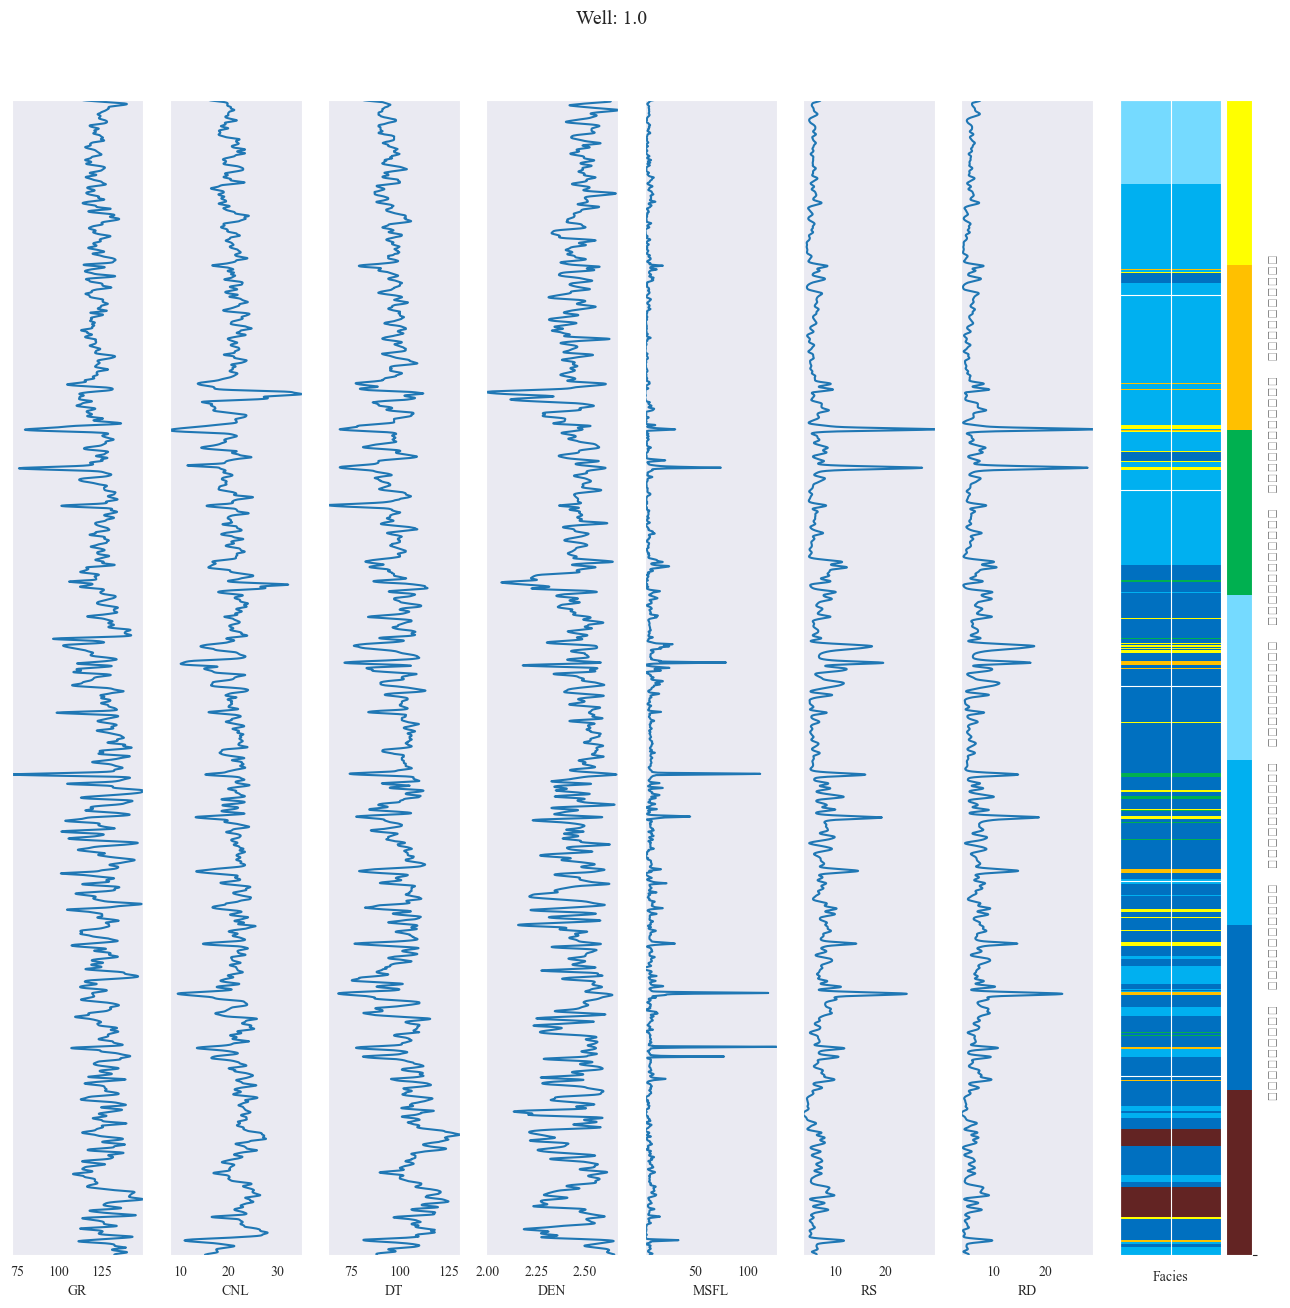

In [54]:
use_depth_log = False
if model_stage == "train":
    # 绘制训练段曲线
    Y_ele = AB_use.loc[:, facies_labels_col]
    if "DEPTH" in a:
        use_depth_log = True
        if "Well Name" in a:
            # well = set(AB_use['Well Name'])
            well = np.unique(AB_use['Well Name'])
            for k in well:
                depth_log = AB_use[AB_use['Well Name'] == k].loc[:, ["DEPTH"]]
                depth_log = np.array(depth_log)
                cucao_depth = np.array(depth_log)
                cucao_depth.shape = (len(cucao_depth),)
                begin_depth = depth_log[0][0]
                end_depth = depth_log[-1][0]
                print("Well Name",k)
                print("begin_depth",begin_depth,"end_depth",end_depth)
                make_facies_log_plot(AB_use[AB_use['Well Name'] == k],facies_colors)
        else:
            depth_log = AB_use.loc[:, ["DEPTH"]]
            depth_log = np.array(depth_log)
            cucao_depth = np.array(depth_log)
            cucao_depth.shape = (len(cucao_depth),)
            begin_depth = depth_log[0][0]
            end_depth = depth_log[-1][0]
            print("Well Name",k)
            print("begin_depth",begin_depth,"end_depth",end_depth)
            make_facies_log_plot(AB_use,facies_colors)
            #plt.show()
        depth_log = np.array(AB_use.loc[:, ["DEPTH"]].reset_index(drop=True))
    else:
        print("No Depth Information")
else:
    if "DEPTH" in a:
        use_depth_log = True
        depth_log = A_read.loc[:, ["DEPTH"]]
        depth_log = np.array(depth_log)
        cucao_depth = np.array(depth_log)
        cucao_depth.shape = (len(cucao_depth),)
        if use_low_R_data == True:
            begin_depth = depth_log[0][0]    
        else:
            begin_depth = depth_log[seq_length][0]
        end_depth = depth_log[-1][0]
        print("begin_depth",begin_depth,"end_depth",end_depth)
    else:
        print("No Depth Information,all method is end!!!")
        # exit()
print("use_depth_log:",use_depth_log)

In [55]:
facies_labels[-1]

'低有机质块状粉砂岩相'

## Set independent variable and dependent variable data（设置自变量应变量数据）

Take logarithmic value of resistivity curve（电阻率曲线取对数值）

In [56]:
if model_stage == "train":
    inputY = AB_use.dropna().reset_index(drop = True).loc[:, facies_labels_col]
    inputY_calc = AB_use.dropna().reset_index(drop = True).loc[:, facies_labels_col]
    inputX = AB_use.dropna().reset_index(drop = True).loc[:,input_vectors]
    # print(inputY)
    # print(inputY_calc)
    if train_use_weight == False:
        sample_weight = np.ones(len(inputY))
        # print(AB_Y)
    else:
        # 设定权重矩阵
        sample_weight = AB_use.loc[:, weight_coloum]
else:
    inputX = A_read.dropna().reset_index(drop = True).loc[:,input_vectors]
    inputY = AB_use.dropna().reset_index(drop = True).loc[:, facies_labels_col]

### 电阻率取对数

In [57]:
# electric_log = ["RD","RS","RLLD","RLLS","MSFL"]
# for item in electric_log:
#     if item in input_vectors:
#         print(item)
#         for i in range(len(inputX)):
#             if (inputX.loc[:,item][i]) <= 0.01:
#                 inputX.loc[:,item][i] = 0.01 
#         inputX.loc[:,item] = np.log10(inputX.loc[:,item])
    


In [58]:
constant_value = 5

### 线性变换渗透率范围

In [59]:
# if "渗透率" in a:
#     inputY.loc[:,element_name] = np.log10(inputY.loc[:,element_name]) + constant_value
#     inputY_calc.loc[:,reference] = np.log10(inputY_calc.loc[:,reference]) + constant_value

## Category distribution of training data(训练数据类别分布)

In [60]:
if model_stage == "train":
    AB_use.dropna().reset_index(drop = True)

## Normalization operations(归一化操作)

In [61]:
# 设置输入曲线范围,由于取了对数，所以RD和RS设置下限-1
DT = [40,200]
# AC = [140,300]
AC = [40,300]
CAL = [4,25]
CNL = [0,50]
CNC = [0,45]
DEN = [1,3]
ZDEN = [1,3]
GR = [50,280]
PE = [0,40]
RD = [0,5]
RS = [0,5]
RLLD = [-5,5]
RLLS = [-5,5]
MSFL = [-1,4]
HRD = [-6,6]
HRM = [-6,6]
ILD_log10 = [-5,5]
DeltaPHI = [-30,30]
PHIND = [0,100]
PE = [0,20]
NM_M = [0,2]
RELPOS = [0,1]


DWCALC = [0.01, 0.8] 
DWCLAY = [0.01, 0.8] 
DWDOLO = [0.01, 0.8] 
DWPLAG = [0.01, 0.8] 
DWQUAR = [0.01, 0.8]

In [62]:
# # 测井曲线计算的物性参数
# POR_CALC = [0,17]
# SW_CALC = [4,100]
# PERM_CALC = [-3 + constant_value, 2 + constant_value]

# # 岩石物理实验测量的物性参数
# POR = [0,17]
# SW = [4,100]
# PERM = [-3+ constant_value, 2 + constant_value]

# DTXX = [100,300]
# DTC = [40,300]
# DTS = [40,600]

创建字典，根据输入的数据维度调正归一化的内容

In [63]:
# u_log = {"AC": AC, "CNL": CNL, "DEN": DEN, "GR": GR, "RD": RD, "RS": RS,"RLLD": RLLD, "RLLS": RLLS}
# e_log = {"孔隙度": POR, "饱和度": SW, "渗透率": PERM}
# e_CALC_log = {"POR": POR_CALC, "SW": SW_CALC, "PERM": PERM_CALC}

u_log = {"DT":DT,"AC": AC,"CNL": CNL, "DEN": DEN, "GR": GR, "RD": RD, "RS": RS,"MSFL":MSFL, "RLLD": RLLD, "RLLS": RLLS,"ILD_log10":ILD_log10,"DeltaPHI":DeltaPHI,"PHIND":PHIND,"PE":PE,"NM_M":NM_M,"RELPOS":RELPOS, 
          'DWCALC': DWCALC,'DWCLAY': DWCLAY,'DWDOLO':DWCLAY,'DWPLAG':DWCLAY,'DWQUAR':DWCLAY}
# e_log = {"DTS":DTS,"DTXX":DTXX,"AC": AC, "CNL": CNL, "DEN": DEN, "GR": GR, "RD": RD, "RS": RS,"RLLD": RLLD, "RLLS": RLLS}
# e_CALC_log = {"DT":DT,"DTS":DTS,"DTC":DTC,"AC": AC, "CNL": CNL, "DEN": DEN, "GR": GR, "RD": RD, "RS": RS,"RLLD": RLLD, "RLLS": RLLS}

In [64]:
u_log_name = []
# 关键在于 input_vectors''
for i in input_vectors:
    u_log_name.append(u_log[i])
    
u_log_name

[[50, 280], [0, 50], [40, 200], [1, 3], [-1, 4], [0, 5], [0, 5]]

In [65]:
# e_log_name = []
# for i in element:
#     e_log_name.append(e_log[i])
# e_log_name

In [66]:
# e_calc_log_name = []
# for i in reference:
#     e_calc_log_name.append(e_CALC_log[i])
# e_calc_log_name

In [67]:
# def zero_one_scaler(data,log_name):
#     ''' Normalization'''
#     result = data.copy()
#     # result = np.zeros(data.shape)
#     for i in range(len(log_name)):
#                 # 严格控制范围
#         it_data = np.array(data.iloc[:,i])
#         for j in range(len(it_data)):
#             if it_data[j] < log_name[i][0]:
#                 it_data[j] = log_name[i][0]
#             if it_data[j]  > log_name[i][1]:
#                 it_data[j] = log_name[i][1]
        
#         numerator = it_data - log_name[i][0]
#         # numerator_1 = data.iloc[:,i]-log_name[i][1]
#         denominator = log_name[i][1]-log_name[i][0]
#         result.iloc[:,i] = numerator / (denominator + 1e-8)
        
#     return  result

In [68]:
#inputY

In [69]:
# min(inputY-1)

## Lithofacies category number transformation

In [70]:
# AB_G = sen.zero_one_scaler(inputX,u_log_name)

# 不做归一化
AB_G = inputX
print(AB_G.shape)

(11830, 7)


In [71]:
set(facies_labels)

{'中低有机质块状白云岩相',
 '中有机质纹层状页岩相',
 '低有机质块状介壳灰岩相',
 '低有机质块状粉砂岩相',
 '低有机质纹层状页岩相',
 '高有机质层状页岩相',
 '高有机质纹层状页岩相'}

In [72]:
class_begin = 0  # default = 0, 默认类别标签从0开始
if model_stage == "train" or model_stage == "test":
#     inputY_train = sen.zero_one_scaler(inputY,e_log_name)
#     inputY_calc_train = sen.zero_one_scaler(inputY_calc,e_calc_log_name)
#     AB_Y_G = inputY_train.loc[:,[element_name]]
#     AB_Y_calc_G = inputY_calc_train.loc[:,[reference_name]]

    if min(inputY) == 1:
        print("类别标签从1开始")
        class_begin = 1
        y = tf.keras.utils.to_categorical(inputY-1,num_classes=len(facies_labels))
    elif min(inputY) == 0:
        print("类别标签从0开始")
        y = tf.keras.utils.to_categorical(inputY,num_classes=len(facies_labels))
    else:
        print("检查类别标签")
        exit()

    AB_Y_G = y #+ 1e-8
    AB_Y_calc_G  = y #+ 1e-8
    print("zero_one_scaler is finished!")
    print(AB_Y_G.shape)
    print(AB_Y_calc_G.shape)

类别标签从0开始
zero_one_scaler is finished!
(11830, 7)
(11830, 7)


0
高有机质层状页岩相
1
高有机质纹层状页岩相
2
中有机质纹层状页岩相
3
低有机质纹层状页岩相
4
中低有机质块状白云岩相
5
低有机质块状介壳灰岩相
6
低有机质块状粉砂岩相
高有机质层状页岩相       477
高有机质纹层状页岩相     5470
中有机质纹层状页岩相     4260
低有机质纹层状页岩相      860
中低有机质块状白云岩相     151
低有机质块状介壳灰岩相     220
低有机质块状粉砂岩相      392
Name: count, dtype: int64


D:\Program Files\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  func(*args, **kwargs)
D:\Program Files\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from current font.
  func(*args, **kwargs)
D:\Program Files\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from current font.
  func(*args, **kwargs)
D:\Program Files\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 36136 (\N{CJK UNIFIED IDEOGRAPH-8D28}) missing from current font.
  func(*args, **kwargs)
D:\Program Files\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 23618 (\N{CJK UNIFIED IDEOGRAPH-5C42}) missing from current font.
  func(*args, **kwargs)
D:\Program Files\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 2936

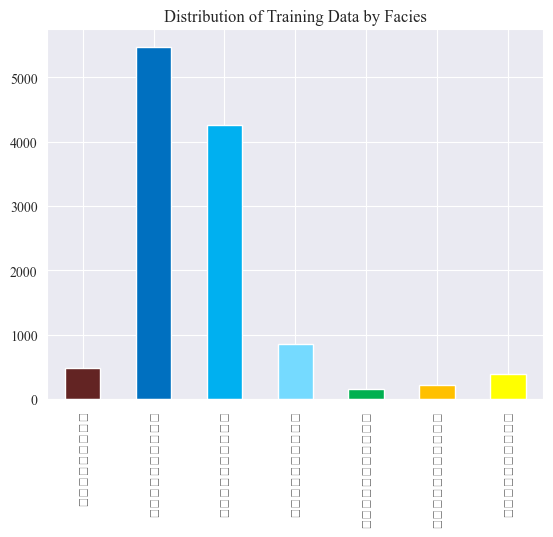

In [73]:
facies_labels_use = []
facies_colors_use = []

facies_counts = AB_use[facies_labels_col].value_counts().sort_index()
#use facies labels to index each count

for i in range(len(facies_counts)):
    # 如果类别从1开始
    if(class_begin ==1):
        use_facies_id = facies_counts.index[i] - 1
    elif(class_begin ==0):
        use_facies_id = facies_counts.index[i]
    print(use_facies_id)
    print(facies_labels[use_facies_id])
    facies_labels_use.append(facies_labels[use_facies_id])
    facies_colors_use.append(facies_colors[use_facies_id])

facies_counts.index = facies_labels_use

facies_counts.plot(kind='bar',color=facies_colors_use, 
                   title='Distribution of Training Data by Facies')
print(facies_counts)

In [74]:
facies_colors_use

['#632423', '#0070C0', '#00B0F0', '#75DAFF', '#00B050', '#FFC000', '#FFFF00']

In [75]:
facies_labels_use

['高有机质层状页岩相',
 '高有机质纹层状页岩相',
 '中有机质纹层状页岩相',
 '低有机质纹层状页岩相',
 '中低有机质块状白云岩相',
 '低有机质块状介壳灰岩相',
 '低有机质块状粉砂岩相']

In [76]:
if model_stage == "train":
    print(np.sum(facies_counts))
    print(np.unique(AB_use[facies_labels_col]))

11830
[0 1 2 3 4 5 6]


### Draw the normalized curve(绘制归一化后的曲线)

In [77]:
facies_labels_col

'Facies'

In [78]:
def make_facies_log_plot_2(logs,sample_index, facies_colors):
    #make sure logs are sorted by depth
    # logs = logs.sort_values(by = DEPTH_col_name)
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    # sample_index = np.arange(len(AB_G))
    # ztop=logs[DEPTH_col_name].min(); zbot=logs[DEPTH_col_name].max()
    ztop = sample_index[0]; zbot = sample_index[-1]
    
    if model_stage == "train":
        label_col = facies_labels_col
    else:
        label_col = "Prediction"
    # print(logs[label_col].values)
    cluster = np.repeat(np.expand_dims(logs[label_col].values,1), 100, 1)
    total_fig_cols = len(input_vectors)+ 1
    f, ax = plt.subplots(nrows=1, ncols=len(input_vectors) + 1, figsize=(total_fig_cols * 2,40))
    for i in range(len(input_vectors)):
        ax[i].plot(logs[input_vectors[i]], sample_index)
    final_line = len(input_vectors)
 
    im = ax[final_line].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin = 1,vmax = len(facies_colors))
    
    divider = make_axes_locatable(ax[final_line])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((3*' ').join(facies_labels))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
        ax[i].set_xlabel(input_vectors[i])
        ax[i].set_xlim(logs[input_vectors[i]].min(),logs[input_vectors[i]].max())
        
    for i in range(len(ax)-1):
        ax[i].set_yticklabels([]);
        
    if model_stage == "train" :   
        ax[final_line].set_xlabel('Facies')    
        ax[final_line].set_yticklabels([])
        ax[final_line].set_xticklabels([])
    # f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)
    f.suptitle("岩相分析", fontsize=14,y=0.94)
    if model_stage == "train":
        pred_image_save_path = model_training_img_file_saving_path 
        pred_image_name = model_training_img_name
        plt.savefig(model_training_img_file_saving_path + model_training_img_name +  str(well_name) + '_tendency.png', dpi=96,  bbox_inches='tight')

    else:
        pred_image_save_path = model_testing_img_file_saving_path 
        pred_image_name = model_testing_image_name
        plt.savefig(pred_image_save_path + pred_image_name + '_PredictionAll.png', dpi=96,  bbox_inches='tight')

In [79]:
sample_index = np.arange(len(AB_G))
# sample_index

In [80]:
# type(inputY)

C:\Users\xbs\AppData\Local\Temp\ipykernel_19352\1136898078.py:52: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  plt.savefig(model_training_img_file_saving_path + model_training_img_name +  str(well_name) + '_tendency.png', dpi=96,  bbox_inches='tight')
C:\Users\xbs\AppData\Local\Temp\ipykernel_19352\1136898078.py:52: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from current font.
  plt.savefig(model_training_img_file_saving_path + model_training_img_name +  str(well_name) + '_tendency.png', dpi=96,  bbox_inches='tight')
C:\Users\xbs\AppData\Local\Temp\ipykernel_19352\1136898078.py:52: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from current font.
  plt.savefig(model_training_img_file_saving_path + model_training_img_name +  str(well_name) + '_tendency.png', dpi=96,  bbox_inches='tight')
C:\Users\xbs\AppData\Local\Temp\ipykernel_19352\1136898078.py:52: UserWarning: Glyph 36136 (\N{CJK UNIFIED IDEOGRAPH-8

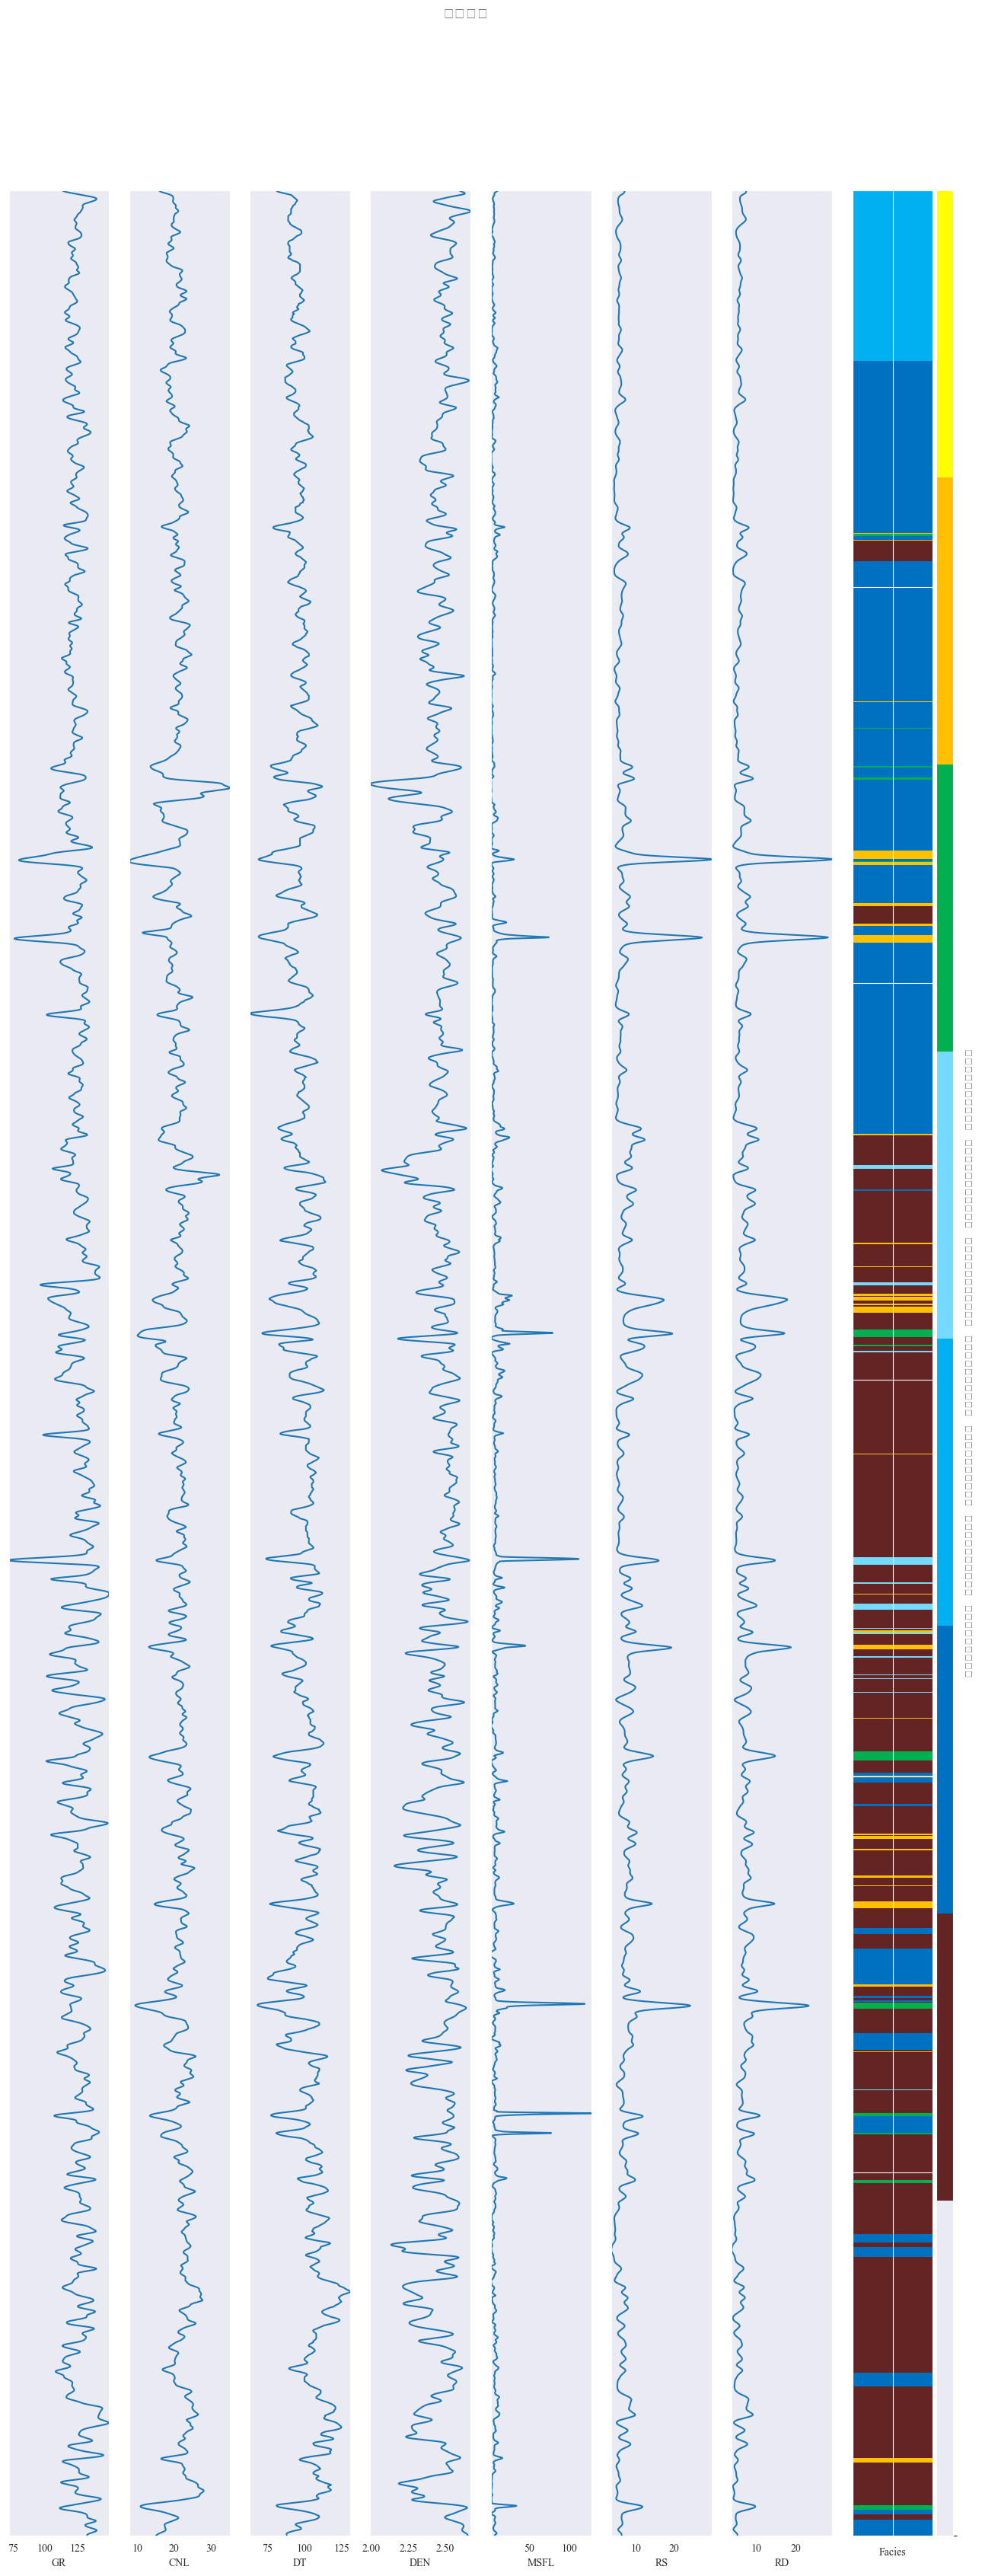

In [81]:
if model_stage == "train":
    df_data = pd.concat([AB_G,inputY],axis=1)
    make_facies_log_plot_2(df_data,sample_index,facies_colors) 
    plt.show()

## Input the independent variables data preparation(输入自变量数据准备)

In [82]:
if model_stage == "train":
    AB_Y = np.array(AB_Y_G)
    AB_Y_calc = np.array(AB_Y_calc_G) 
AB_X = np.array(AB_G)

In [83]:
AB_X

array([[113.4619,  15.9331,  81.    , ...,  11.5818,   6.9659,   7.4271],
       [113.5189,  15.9363,  80.9627, ...,  11.1305,   6.9929,   7.4587],
       [113.6427,  15.9558,  80.9812, ...,  10.6897,   7.0149,   7.4848],
       ...,
       [132.8175,  15.3162,  88.0898, ...,   6.6647,   6.3001,   5.3157],
       [132.7322,  15.2346,  88.0769, ...,   6.4558,   6.3048,   5.3237],
       [132.6616,  15.1481,  88.0219, ...,   6.2619,   6.3116,   5.3343]])

In [84]:
# AB_Y[1000]

### Split the training set and the validation set(训练集验证集划分)

Determine whether serialization is required based on the needs of the model
(根据模型需要判定是否需要序列化)

In [85]:
if (flag == 1) or (flag == 2):
    print("不需要序列化")
    if model_stage == "train":
        # 训练阶段
        dataX = AB_X
        dataY = AB_Y
        dataY_calc = AB_Y_calc
        sss = model_selection.ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
        for train_index, test_index in sss.split(dataX):
        # print("TRAIN:", train_index, "TEST:", test_index)
            train_X, test_X = dataX[train_index], dataX[test_index]
            train_Y, test_Y = dataY[train_index], dataY[test_index]
            train_Y_calc, test_Y_calc = dataY_calc[train_index], dataY_calc[test_index]
            train_weight, test_weight = sample_weight[train_index],sample_weight[test_index]
    else:
        # 测试阶段
        testALL_A_X = AB_X
    if use_depth_log == True:
        DEPTH_AddReslution = depth_log
    else:
        DEPTH_AddReslution = None
else:
    print("序列化")
    if model_stage == "train":
#         if (flag == 1) or (flag == 2):
#             print("不需要序列化")
#             dataX = AB_X
#             dataY = AB_Y
#             dataY_calc = AB_Y_calc
#         else:
        dataX, dataY = sen.build_All_Train_dataset(AB_X, AB_Y, seq_length)
        dataY_calc = sen.build_All_Y_dataset( AB_Y_calc, seq_length)
        weight_matrix = sen.build_All_Y_dataset(sample_weight,seq_length)
            # 使用model_selection.ShuffleSplit抽取样本
        sss = model_selection.ShuffleSplit(n_splits = 10, test_size=0.2, random_state=0)
        for train_index, test_index in sss.split(dataX):
        # print("TRAIN:", train_index, "TEST:", test_index)
            trainX, testX = dataX[train_index], dataX[test_index]
            trainY, testY = dataY[train_index], dataY[test_index]
            train_Y_calc, test_Y_calc = dataY_calc[train_index], dataY_calc[test_index]
            train_weight, test_weight = weight_matrix[train_index],weight_matrix[test_index]
        trainX, testX = dataX, dataX
        trainY, testY = dataY, dataY
        train_Y_calc, test_Y_calc = dataY_calc, dataY_calc
        train_weight, test_weight = weight_matrix,weight_matrix
            
    else:
        # 测试阶段
        testALL_A_X = sen.build_All_A_dataset(AB_X, seq_length)
    if use_depth_log == True:
        DEPTH_AddReslution = sen.build_addReslution_DEPTH(depth_log, seq_length)
    else:
        DEPTH_AddReslution = None

序列化


In [86]:
# len(depth_log)

### Confirm the input dimension(确认输入维度)

In [87]:
if (flag == 1) or (flag == 2):
    if model_stage == "train":
        print("input_vectors.length:",len(input_vectors))
        print("train_X.shape:", train_X.shape,"test_X.shape:", test_X.shape)
        print("train_Y.shape:", train_Y.shape,"test_Y.shape:", test_Y.shape)
        print("train_Y_calc.shape:", train_Y_calc.shape,"test_Y_calc.shape:", test_Y_calc.shape)
        print("train_weight.shape:", train_weight.shape,"test_weight.shape:", test_weight.shape)
    else:
        print("testALL_A_X.shape:", testALL_A_X.shape,"\n","input_vectors.length:",len(input_vectors))
else:
    if model_stage == "train":
        print("input_vectors.length:",len(input_vectors))
        print("trainX.shape:", trainX.shape,"testX.shape:", testX.shape) 
        print("trainY.shape:", trainY.shape,"testY.shape:", testY.shape)
        print("train_Y_calc.shape:", train_Y_calc.shape,"test_Y_calc.shape:", test_Y_calc.shape)
        print("train_weight.shape:", train_weight.shape,"test_weight.shape:", test_weight.shape)
    else:
        print("testALL_A_X.shape:", testALL_A_X.shape,"\n","input_vectors.length:",len(input_vectors))

input_vectors.length: 7
trainX.shape: (11810, 20, 7) testX.shape: (11810, 20, 7)
trainY.shape: (11810, 7) testY.shape: (11810, 7)
train_Y_calc.shape: (11810, 7) test_Y_calc.shape: (11810, 7)
train_weight.shape: (11810,) test_weight.shape: (11810,)


In [88]:
# train_weight

# Network instantiation(网络实例化)

## Build a network or load a model(构建网络或载入模型)

In [89]:
def model_type_select(model_type):
    if model_type == 'DNN':
        return smsc.dnn_model(model_para)
    elif model_type == 'DNN_2':
        return smsc.dnn_model_2(model_para)
    elif model_type == 'RBF':
        n_layers = 3
        return smsc.rbf_model(train_X,model_para)
    elif model_type == 'LSTM':
        return smsc.lstm_cell_model(model_para)
    elif model_type == 'GRU':
        return smsc.gru_cell_model(model_para)
    elif model_type == 'GRU2':
        return smsc.gru_block_cell_2(model_para)
    # elif model_type == 'NAS':
    #     return nas_cell()
    elif model_type == 'BLSTM':
        return smsc.bi_lstm_cell_model(model_para)
    elif model_type == 'BGRU':
        return smsc.bi_gru_cell_model(model_para)
    elif model_type == 'BiGRU-Atten':
        return smsc.bigru_atten_model(model_para)
    elif model_type == 'BiGRU-Atten2':
        return smsc.bigru_atten_model_2(model_para)
    elif model_type == 'BiGRU-self-Atten':
        return smsc.bigru_self_atten_model(model_para)
    elif model_type == 'WaveNet':
        return smsc.wavenet_model(model_para)
    elif model_type == 'MyWaveNet':
        return smsc.wavenet_model2(model_para)
    elif model_type == 'MyUNet':
        return smsc.my_unet(model_para)
    elif model_type == 'Bilstm_Capsule':
        return smsc.bilstm_capsule_model(model_para)
    elif model_type == 'BLSTM-Atten':
        return smsc.bilstm_atten_model(model_para)
    elif model_type == 'BiLSTM-Atten2':
        return smsc.bilstm_atten_model_2(model_para)
    elif model_type == 'BiLSTM-Atten3':
        return smsc.bilstm_atten_model_3(model_para)
    elif model_type == 'BiLSTM-Atten4':
        return smsc.bilstm_atten_model_4(model_para)
    elif model_type == 'BiLSTM-Atten5':
        return smsc.bilstm_atten_model_5(model_para)
    elif model_type == 'BiLSTM-Atten6':
        return smsc.bilstm_atten_model_6(model_para)
    elif model_type == 'CNN_Atten':
        return smsc.wavenet_atten_model(model_para)
    elif model_type == 'Multihead_Self_Atten':
        return smsc.multihead_model(model_para)
    elif model_type ==  'Bigru_Multihead_Self_Atten':
        return smsc.bigru_multihead_atten_model(model_para)
    elif model_type ==  'Bigru_Multihead_Self_Atten_RBF':
        return smsc.bigru_multihead_atten_rbf_model(model_para)
    elif model_type ==  'Bigru_Multihead_Self_Atten_DNN':
        return smsc.bigru_multihead_atten_dnn_model(model_para)
    else:
        return smsc.bi_lstm_cell_model(model_para)

In [90]:
if model_stage == "test":
    print(pred_model_file)

In [91]:
# from attention_layer import AttentionLayer
# from tensorflow.keras import backend as Kbackend
# from tensorflow.keras.layers import Activation,Lambda, Multiply, Add, Concatenate
# import tensorflow as tf
# # import keras
# from tensorflow.keras.layers import Layer
# from tensorflow.keras import initializers, regularizers, constraints
# from tensorflow.keras.initializers import RandomUniform, Initializer, Constant
# from tensorflow import keras
# from tensorflow.keras import layers
# # from keras_self_attention import SeqSelfAttention
# import numpy as np
# from sklearn.cluster import KMeans
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv1D, Dense, Activation, Dropout, Lambda, Multiply, Add, Concatenate
# from tensorflow.keras.layers import GlobalAveragePooling1D, MaxPool1D, GlobalMaxPool1D, UpSampling1D
# from tensorflow.keras.layers import Concatenate,concatenate

# def wavenet_atten_model(model_parameter):
#     # convolutional operation parameters
#     n_filters = model_parameter.hidden_dim # 32 
#     filter_width = 2
#     # dilation_rates = [2**i for i in range(8)] * 2   # 
#     # dilation_rates = [2**i for i in range(model_parameter.seq_length)] * 2
#     dilation_rates = [2**i for i in range(model_parameter.seq_length)] * 2 
    
#     # define an input history series and pass it through a stack of dilated causal convolution blocks. 
#     history_seq = Input(shape=(model_parameter.seq_length, model_parameter.data_dim))
#     x = history_seq
    
#     # 增加正则化层-2020-03-20
#     x = tf.keras.layers.BatchNormalization()(x)
    
#     skips = []
#     for dilation_rate in dilation_rates:
        
#         # preprocessing - equivalent to time-distributed dense
#         # x = Conv1D(16, 1, padding='same')(x) data_dim
#         # x = Conv1D(model_parameter.seq_length * 2, 1, padding='same')(x)
#         x = Conv1D(model_parameter.data_dim * 4, 1, padding='same')(x)
 
        
#         # filter convolution
#         x_f = Conv1D(filters=n_filters,
#                     kernel_size=filter_width, 
#                     padding='causal',
#                     dilation_rate=dilation_rate)(x)
        
#         # gating convolution
#         x_g = Conv1D(filters=n_filters,
#                     kernel_size=filter_width, 
#                     padding='causal',
#                     dilation_rate=dilation_rate)(x)
        
#         # multiply filter and gating branches
#         # z = Multiply()([Activation('tanh')(x_f),
#         #                Activation('sigmoid')(x_g)])
#         z = Multiply()([Activation('tanh')(x_f),
#                         Activation('relu')(x_g)])
        
#         # postprocessing - equivalent to time-distributed dense
#         # z = Conv1D(16, 1, padding='same')(z)
#         # z = Conv1D(model_parameter.seq_length * 2, 1, padding='same')(z)
#         z = Conv1D(model_parameter.data_dim * 4, 1, padding='same')(z)
        
        
#         # residual connection
#         x = Add()([x, z])

# #         repeated_word_attention = tf.keras.layers.RepeatVector(model_parameter.hidden_dim * 4)(attention_layer)
# #         repeated_word_attention = tf.keras.layers.Permute([2, 1])(repeated_word_attention)
# #         sentence_representation = tf.keras.layers.Multiply()([z, repeated_word_attention])
    
# #         # sentence_representation = tf.keras.layers.Lambda(lambda x: Kbackend.sum(x, axis=1))(sentence_representation)
# #         # skips.append(sentence_representation) 
# #         z = tf.keras.layers.Lambda(lambda x: Kbackend.sum(x, axis=1))(sentence_representation)
#         # collect skip connections
#         skips.append(z)

#     # add all skip connection outputs 
# #     out = Activation('relu')(Concatenate()(skips))
# #     out = Activation('relu')(Add()(skips))
#     out = Add()(skips)

#     # final time-distributed dense layers 
#     # out = Conv1D(128, 1, padding='same')(out)
#     out = Conv1D(model_parameter.data_dim * 2, 1, padding='same')(out)
#     # out = Activation('relu')(out)
#     out = Dropout(model_parameter.dropout_rate)(out)
#     out = Conv1D(1, 1, padding='same')(out)
#     out = GlobalAveragePooling1D()(out)
# #     out = AttentionLayer()(out)
    
#     pred_seq_train = layers.Dense(model_parameter.output_dim)(out)
#     # pred_seq_train = Dropout(model_parameter.dropout_rate)(pred_seq_train)

#     # extract the last 60 time steps as the training target
#     # def slice(x, seq_length):
#     #     return x[:,-seq_length:,:]

#     # pred_seq_train = Lambda(slice, arguments={'seq_length':model_parameter.seq_length})(out)

#     model = Model(history_seq, pred_seq_train)
    
#     optimizer = tf.keras.optimizers.Adam(model_parameter.learning_rate)
#     # optimizer = tf.keras.optimizers.RMSprop(model_parameter.learning_rate)
#     # loss = 'mse', 'mean_squared_error', 'huber_loss'
#     my_loss = 'mse'
#     model.compile(optimizer=optimizer,
#                   loss = my_loss,
#                   metrics=['mae', 'mse'])
#     return model

In [92]:
from tensorflow import keras
from tensorflow.keras import initializers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

class My_Attention_layer(tf.keras.layers.Layer):
    """
        Attention operation, with a context/query vector, for temporal data.
        Supports Masking.
        Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
        "Hierarchical Attention Networks for Document Classification"
        by using a context vector to assist the attention
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(AttentionWithContext())
        """
 
    def __init__(self,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True,supports_masking = True,initializer = None,initializer_bias = None, **kwargs):
 
        self.supports_masking = True
        self.initializer = initializers.get('glorot_uniform')
        self.initializer_bias = initializers.get('zero')
 
        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
 
        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)
 
        self.bias = bias
        super(My_Attention_layer, self).__init__(**kwargs)
 
    def build(self, input_shape):
        assert len(input_shape) == 3
 
        self.W = self.add_weight(name='{}_W'.format(self.name),
                                  shape=(input_shape[-1], input_shape[-1]),
                                 initializer=self.initializer,
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(name='{}_b'.format(self.name),
                                      shape=(input_shape[-1],),
                                     initializer = self.initializer_bias,
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
 
        super(My_Attention_layer, self).build(input_shape)
 
    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None
 
    def call(self, x, mask=None):
        uit = Kbackend.dot(x, self.W)
 
        if self.bias:
            uit += self.b
 
        uit = Kbackend.tanh(uit)
 
        a = Kbackend.exp(uit)
 
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= Kbackend.cast(mask, Kbackend.floatx())
 
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= Kbackend.cast(Kbackend.sum(a, axis=1, keepdims=True) + Kbackend.epsilon(), Kbackend.floatx())
        # print(a)
        # a = K.expand_dims(a)
        # print(x)
        weighted_input = x * a
        # print(weighted_input)
        return Kbackend.sum(weighted_input, axis=1)
 
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])
    
    # https://zhuanlan.zhihu.com/p/86886620
    # 一般来说，父类的config也是需要一并保存的，在自定义网络层时重写get_config
    # 其中base_config即是父类网络层实现的配置参数，最后把父类及继承类的config组装为字典形式即可解决该问题！
    def get_config(self):
        config = {
            "supports_masking":self.supports_masking,
            "initializer":self.initializer,
            "initializer_bias":self.initializer_bias,
            "W_regularizer":self.W_regularizer, 
            "b_regularizer":self.b_regularizer,
            "W_constraint":self.W_constraint, 
            "b_constraint":self.b_constraint,
            "bias":self.bias,
                 }
        base_config = super(My_Attention_layer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
# 原文链接：https://blog.csdn.net/mpk_no1/java/article/details/72862348

In [93]:
# from keras_self_attention import SeqSelfAttention


def bigru_self_atten_model(model_parameter):
    lstm_dim = 50  # 替换model_parameter.hidden_dim
    input_data = tf.keras.layers.Input(shape=(model_parameter.seq_length,model_parameter.data_dim))
    input_data_G = tf.keras.layers.BatchNormalization()(input_data)
    bigru = input_data_G  
    skips = []

    for i in range(model_parameter.n_layers):
        bigru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(model_parameter.hidden_dim * 2,return_sequences=True))(bigru)
        # bigru = tf.keras.layers.Dropout(model_parameter.dropout_rate)(bigru)
        
        attention_layer = My_Attention_layer()(bigru)
        
        # print(attention_layer)
#       # old-attention
#         # attention_layer = Attention_layer(name='Attention_')(bigru)
#         repeated_word_attention = tf.keras.layers.RepeatVector(model_parameter.hidden_dim * 4)(attention_layer)
#         repeated_word_attention = tf.keras.layers.Permute([2, 1])(repeated_word_attention)
#         sentence_representation = tf.keras.layers.Multiply()([bigru, repeated_word_attention])
    
#         sentence_representation = tf.keras.layers.Lambda(lambda x: Kbackend.sum(x, axis=1))(sentence_representation)        
#         skips.append(sentence_representation)
        skips.append(attention_layer)
    

    out_block = Activation('relu')(Concatenate()(skips))
    
    bigru_output = tf.keras.layers.Dense(model_parameter.output_dim, activation='softmax', name='fianl_class_output')(out_block)

    my_optimizer = tf.keras.optimizers.Adam(model_parameter.learning_rate)

    model = tf.keras.models.Model(inputs=[input_data],
                outputs=[bigru_output])
    # model.compile(loss='categorical_crossentropy', optimizer=my_optimizer,metrics=['accuracy'])
    model.compile(loss = smsc.FocalLoss(alpha=1), optimizer = my_optimizer,metrics=['accuracy'])

    return model

## Model visualization(模型可视化)

In [94]:
from distutils.util import strtobool
TF_KERAS = strtobool(os.environ.get('TF_KERAS', '0'))
print(TF_KERAS)

0


In [95]:
# TF_KERAS
if model_stage == "test":
    print(pred_model_json)

In [96]:
model = tf.keras.Model()
if model_stage == "train":
    model =  model_type_select(model_type)
#     model = wavenet_atten_model(model_para)
    # model = sms.bi_lstm_cell_model(model_para)
    # model = bigru_self_atten_model(model_para)
else:
    with open(pred_model_json, "r") as json_file_1:
        json_config_1 = json_file_1.read()
        # 此处加载模型无需判断 
        model = tf.keras.models.model_from_json(json_config_1,custom_objects={'GlorotUniform': tf.keras.initializers.GlorotUniform(),
             'Zeros': tf.keras.initializers.Zeros(),
             'RBFLayer': smsc.RBFLayer,
             'AttentionLayer': smsc.AttentionLayer,
             'Self_Attention_layer': smsc.Self_Attention_layer,
             'MultiHead': smsc.MultiHead,
             'MultiHeadAttention': smsc.MultiHeadAttention})
        model.load_weights(pred_model_file)
print(model.summary())

D:\Program Files\Python310\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 7)]      0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 20, 7)       28          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 bidirectional (Bidirectional)  (None, 20, 98)       17052       ['batch_normalization[0][0]']    
                                                                                                  
 dropout (Dropout)              (None, 20, 98)       0           ['bidirectional[0][0]']    

In [97]:
# 定义结果打印函数
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0:
            print('已经训练完'+ str(epoch) +'Epoch')
            print('.', end='')

In [98]:
#if  pg.find_graphviz() is not None:
if model_stage == "train":
    model_image_path = model_path
else:
    model_image_path = csv_file_saving_path
if plot_modelnet == True:
    tf.keras.utils.plot_model(model,to_file= model_image_path + element_name + '_' + model_type + '_net.png',
               show_shapes=True,
               show_layer_names=True,
               rankdir='TB',
               expand_nested=False,
               dpi=96)
    print(model_image_path + element_name + '_' + model_type + '_net.png')

model/lithosfacies_bigru_multihead_self_atten_dnn_train/7_Bigru_Multihead_Self_Atten_DNN_net.png


## The log storage content is set(日志保存内容设定)

In [99]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

if not os.path.exists(log_path):
    # 针对第一次训练
    os.mkdir(log_path)
my_log_dir = os.path.join(log_path,model_type.lower())
print("my_log_dir:",my_log_dir)
if not os.path.exists(my_log_dir):
    os.makedirs(my_log_dir)

str_name = model_name.split(".h5")[0]
# log_name = str_name + "-{}".format(int(time.time()))
log_name = "{}".format(int(time.time()))
curve_reconstract_logs_child_dir = os.path.join(my_log_dir,log_name)
print("curve_reconstract_logs_child_dir:",curve_reconstract_logs_child_dir)
if not os.path.exists(curve_reconstract_logs_child_dir):
    os.mkdir(curve_reconstract_logs_child_dir)

my_log_dir: logs/bigru_multihead_self_atten_dnn
curve_reconstract_logs_child_dir: logs/bigru_multihead_self_atten_dnn\1725592282


# Model training and testing(模型训练与测试)

## Model training and validation（模型训练与验证）

fit函数解析 
```
fit( x, y, batch_size=32, epochs=10, verbose=1, callbacks=None,
validation_split=0.0, validation_data=None, shuffle=True, 
class_weight=None, sample_weight=None, initial_epoch=0)
```

* x：输入数据。如果模型只有一个输入，那么x的类型是numpy array，如果模型有多个输入，那么x的类型应当为list，list的元素是对应于各个输入的numpy array  
* y：标签，numpy array  
* batch_size：整数，指定进行梯度下降时每个batch包含的样本数。训练时一个batch的样本会被计算一次梯度下降，使目标函数优化一步。  
* epochs：整数，训练终止时的epoch值，训练将在达到该epoch值时停止，当没有设置initial_epoch时，它就是训练的总轮数，否则训练的总轮数为epochs - inital_epoch  
* verbose：日志显示，0为不在标准输出流输出日志信息，1为输出进度条记录，2为每个epoch输出一行记录  
* callbacks：list，其中的元素是keras.callbacks.Callback的对象。这个list中的回调函数将会在训练过程中的适当时机被调用，参考回调函数  
* validation_split：0~1之间的浮点数，用来指定训练集的一定比例数据作为验证集。验证集将不参与训练，并在每个epoch结束后测试的模型的指标，如损失函数、精确度等。注意，validation_split的划分在shuffle之前，因此如果你的数据本身是有序的，需要先手工打乱再指定validation_split，否则可能会出现验证集样本不均匀。  
* validation_data：形式为（X，y）的tuple，是指定的验证集。此参数将覆盖validation_spilt。
* shuffle：布尔值或字符串，一般为布尔值，表示是否在训练过程中随机打乱输入样本的顺序。若为字符串“batch”，则是用来处理HDF5数据的特殊情况，它将在batch内部将数据打乱。  
* class_weight：字典，将不同的类别映射为不同的权值，该参数用来在训练过程中调整损失函数（只能用于训练）  
* sample_weight：权值的numpy array，用于在训练时调整损失函数（仅用于训练）。可以传递一个1D的与样本等长的向量用于对样本进行1对1的加权，或者在面对时序数据时，传递一个的形式为（samples，sequence_length）的矩阵来为每个时间步上的样本赋不同的权。这种情况下请确定在编译模型时添加了sample_weight_mode=’temporal’。Timestep-wise sample weighting (use of sample_weight_mode="temporal") is restricted to outputs that are at least 3D, i.e. that have a time dimension.
* initial_epoch: 从该参数指定的epoch开始训练，在继续之前的训练时有用。  

In [100]:
def scheduler(epoch):
# 每隔10个epoch，学习率减小为原来的1/10
    if epoch % 10 == 0 and epoch != 0:
        lr = Kbackend.get_value(model.optimizer.lr)
        Kbackend.set_value(model.optimizer.lr, lr * 0.1)
        print("lr changed to {}".format(lr * 0.1))
    return Kbackend.get_value(model.optimizer.lr)

# keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
if learning_rate_deacy_policy == 1:
    reduce_lr = [
        LearningRateScheduler(scheduler),
         # tf.keras.callbacks.ModelCheckpoint(model_file,
          #                      save_best_only=True)
    ]
elif learning_rate_deacy_policy == 2:
    reduce_lr = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience = 5,verbose=2, mode='auto'),
        # PrintDot(),  5
    ]
        
else:
     # reduce_lr =  PrintDot()
    reduce_lr = [
        PrintDot(),
    ]
    
# 原文链接：https://blog.csdn.net/zzc15806/article/details/79711114

In [101]:
my_callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir =  curve_reconstract_logs_child_dir),
    tf.keras.callbacks.ModelCheckpoint(model_file,save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=8,mode='auto', min_delta=1e-9),
]


# tensorboard = TensorBoard(log_dir = my_log_dir + '\{}'.format(log_name))

In [102]:
# My_X.shape,My_Y.shape

In [103]:
if model_stage == "train":
    if (flag == 1) or (flag == 2):
        print("flag:",flag)
        My_X = train_X
        My_Y = train_Y
        My_Test_X = test_X
        My_Test_Y = test_Y
        My_Weight =  train_weight #
        My_class_Weight =  None# 'auto' # {"0":}
    else:
        print("flag:",flag)
        My_X = trainX # trainX, dataX
        My_Y = trainY # trainY， dataY 
        My_Test_X = testX
        My_Test_Y = testY
        My_Weight = train_weight  # train_weight ,weight_matrix
        My_class_Weight = None # 'auto'
        # history = model.fit(train_X, train_Y, batch_size=BATCH_SIZE,epochs=EPOCHS,
        #                validation_split = 0.1, verbose=1,callbacks=[PrintDot()])
    #     dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
    #     train_dataset  = dataset.shuffle(len(train_Y)).batch(1)
    #     t_dataset = tf.data.Dataset.from_tensor_slices((test_X,test_Y))
    #     val_dataset  = dataset.shuffle(len(test_Y)).batch(1)
    #     history = model.fit(train_dataset, epochs=EPOCHS,
    #                      validation_data = val_dataset, verbose=1,callbacks=[PrintDot()])

    if batch_size_strategy == True:
        if save_logs == False:
            history = model.fit(My_X, My_Y, batch_size = BATCH_SIZE,epochs=EPOCHS,validation_data = (My_Test_X,My_Test_Y), verbose=1,callbacks=reduce_lr)
        else:
            history = model.fit(My_X, My_Y, batch_size = BATCH_SIZE,epochs=EPOCHS,validation_data = (My_Test_X,My_Test_Y), verbose=1,callbacks=my_callbacks)
    else:
        if save_logs == False:
            history = model.fit(My_X, My_Y, epochs = EPOCHS,validation_data = (My_Test_X,My_Test_Y), class_weight = My_class_Weight, verbose=1,callbacks = reduce_lr)
        else:
            history = model.fit(My_X, My_Y, epochs = EPOCHS,validation_data = (My_Test_X,My_Test_Y), class_weight = My_class_Weight, verbose=1,callbacks = my_callbacks)
else:
    print("model_stage:", model_stage)

flag: 3
Epoch 1/30
174/370 [=============>................] - ETA: 34s - loss: 0.4656 - accuracy: 0.6832

KeyboardInterrupt: 

## Model testing(模型测试)

model.evaluate输入数据(data)和金标准(label),然后将预测结果与金标准相比较,得到两者误差并输出.  
model.predict输入数据(data),输出预测结果  
* 是否需要真实标签(金标准)  
model.evaluate需要,因为需要比较预测结果与真实标签的误差  
model.predict不需要,只是单纯输出预测结果,全程不需要金标准的参与.  

In [104]:
def plot_history(history,model_training_img_file_saving_path,model_training_img_name):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Val Error')
    # plt.ylim([0,5])
    plt.legend()
    plt.savefig(model_training_img_file_saving_path + model_training_img_name + '_MAE.png', dpi=300,  bbox_inches='tight')

    plt.figure()
    plt.ylim(0,1.05)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],label='Train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],label = 'Val accuracy')
    plt.grid
    # plt.ylim([0,20])
    plt.legend()
    
    plt.savefig(model_training_img_file_saving_path + model_training_img_name +"_" + element_name + '_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
        learning_rate) + "h_dim" + str(hidden_dim) + "_epoch_" + str(EPOCHS) + '_loss.png', dpi=300,  bbox_inches='tight')
    plt.show()
    

In [105]:
if model_stage == "train":
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    print(hist.tail())
    plot_history(history,model_training_img_file_saving_path,model_training_img_name)

In [106]:
if model_stage == "train":
    if flag != 4:
        train_loss_csv_name = train_well_name + "_" + model_type.lower() + "_" + str(len(input_vectors)) + '-facies_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
        learning_rate) + "h_dim" + str(hidden_dim) + "_epoch_" + str(EPOCHS) + "_trainloss.csv"
    else:
        train_loss_csv_name = train_well_name + "_" + model_type.lower() + "_" + str(len(input_vectors)) + '-facies_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
        learning_rate) + "h_dim" + str(hidden_dim) + "_epoch_" + str(EPOCHS) + "_alltrainloss.csv"
    hist.to_csv(csv_file_saving_path + train_loss_csv_name,mode='w',float_format='%.6f',index=None,header=True)

In [107]:
hist

<function matplotlib.pyplot.hist(x, bins=None, range=None, density=False, weights=None, cumulative=False, bottom=None, histtype='bar', align='mid', orientation='vertical', rwidth=None, log=False, color=None, label=None, stacked=False, *, data=None, **kwargs)>

In [108]:
if model_stage == "train":
    train_loss_csv = model_name.split('.h5')[0] + '_'+ sen.tid_maker() +'.csv'
    hist.to_csv(model_save_path + train_loss_csv,mode='w',float_format='%.4f',index=None,header=True)

In [109]:
print(model_name.split('.h5')[0])

古页1地质岩相-0512_facies_vectors_0_bigru_multihead_self_atten_dnn_7-facies_5_layers__lr_0.005h_dim49_seq_length_20_epoch_30


## Confused Matrix(混淆矩阵)

In [110]:
from sklearn.metrics import confusion_matrix
from classification_utilities import display_cm, display_adj_cm

In [111]:
if model_stage == "train":
        predictions = model.predict(My_Test_X)
#         np.testing.assert_allclose(predictions, testY, atol=1e-6)
        loss, accuracy = model.evaluate(My_Test_X, My_Test_Y, verbose=2)
        sample_index = np.arange(len(My_Test_Y))
        max_test = np.argmax(My_Test_Y, axis=1)
        max_predictions = np.argmax(predictions, axis=1)
# else:
#    A_Y_predict = model.predict(testALL_A_X)

In [112]:
# predictions

In [113]:
np.argmax([0.00000033, 0.00944981, 0.97227716, 0.00000005, 0.01238397,
        0.00106168])

2

In [114]:
# 待修改
def count_facies(max_predictions_out,facies_labels):
    facies_use = []
    predictions_dataframe = pd.DataFrame(max_predictions_out,columns=[facies_labels_col])
    facies_counts = predictions_dataframe.value_counts().sort_index()
    #use facies labels to index each count   
    for i in range(len(facies_counts)):
        if(class_begin == 1):
            # 如果类别从1开始
            use_facies_id = facies_counts.index[i] - 1
        elif(class_begin == 0):
            use_facies_id = facies_counts.index[i]
        print(use_facies_id)
        print(facies_labels[use_facies_id])
        facies_use.append(facies_labels[use_facies_id])
    return facies_use

In [115]:
if model_stage == "train":
    conf = confusion_matrix(max_test, max_predictions)
    display_cm(conf, facies_labels_use, hide_zeros=True)
    plt.figure(figsize=(10,10))
    plt.rc('font',family='Simsun')
    sns.heatmap(conf, xticklabels=facies_labels_use, yticklabels=facies_labels_use, annot=True, fmt="d", annot_kws={"size": 20});
    plt.title("Confusion matrix", fontsize=20)
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.savefig(model_training_img_file_saving_path + model_training_img_name +"_" + element_name + '_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
        learning_rate) + "h_dim" + str(hidden_dim) + "_epoch_" + str(EPOCHS) + '_confusion_matrix.png', dpi=300,  bbox_inches='tight')
    plt.show()

In [116]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf)) + 1e-8
    return acc


def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf)) + 1e-8

In [117]:
def per_class_accuracy(conf):
    per_class_correct = 0.
    nb_classes = conf.shape[0]
    per_acc = []
    for i in np.arange(0,nb_classes):
        acc = 0
        per_class_correct = conf[i][i]
        per_class_sum = 0
        per_class_sum = per_class_sum + sum(conf[i])
        print(per_class_sum)
        acc = per_class_correct/per_class_sum + 1e-8
#         acc = per_class_correct/sum(sum(conf))
        per_acc.append(acc)
    return per_acc

In [118]:
if model_stage == "train":
    print(conf)

In [119]:
if model_stage == "train":
    print('Facies classification accuracy = %f' % accuracy(conf))
#     print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))
    per_class_accuracy_list = per_class_accuracy(conf)
    for i in range(len(per_class_accuracy_list)):
        print(i,' class facies classification accuracy = %f' % per_class_accuracy_list[i])

## Plot ROC(绘制ROC)

In [120]:
from sklearn.metrics import roc_curve, auc

In [121]:
n_classes = len(facies_labels_use)

In [122]:
# Compute ROC curve and ROC area for each class
if model_stage == "train":
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(My_Test_Y[:, i], predictions[:, i])   
        #max_test样例真实标签，max_predictions学习器预测的样例的概率 
        roc_auc[i] = auc(fpr[i], tpr[i])   
        #计算ROC曲线下方的面积，fpr假正例率数组(横坐标)，tpr真正例率数组(纵坐标） 

In [123]:
if model_stage == "train":
    fpr["micro"], tpr["micro"], _ = roc_curve(My_Test_Y.ravel(), predictions.ravel())   #ravel函数将矩阵展开成向量
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [124]:
# https://blog.csdn.net/cymy001/article/details/79613787
# First aggregate all false positive rates
if model_stage == "train":
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))   #np.concatenate将“特征维度相同数组”纵向拼接

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)   #np.zeros_like创建一个和参数all_fpr数组维度相同的全0数组
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])   
        #interp一维线性插值，fpr和tpr是插值结点横纵坐标，all_fpr是已知中间节点横坐标(得到插值曲线后，求其纵坐标)
    #https://docs.scipy.org/doc/numpy/reference/generated/numpy.interp.html#numpy.interp

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [125]:
if model_stage == "train":
    print(roc_auc)

In [126]:
# Plot all ROC curves
# from itertools import cycle
if model_stage == "train":
    plt.rcParams['figure.figsize']=(8,6)
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.4f})' ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':')

    plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.4f})' ''.format(roc_auc["macro"]),
             color='navy', linestyle=':')

    # colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])   #python3里的无穷循环器
    line_colors = facies_colors_use
    for i, line_color in zip(range(n_classes), line_colors):
        plt.plot(fpr[i], tpr[i], color=line_color, label='ROC curve of class {0} (area = {1:0.4f})' ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.savefig(model_training_img_file_saving_path + model_training_img_name +"_" + element_name + '_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
        learning_rate) + "h_dim" + str(hidden_dim) + "_epoch_" + str(EPOCHS) + '_ROC.png', dpi=330,  bbox_inches='tight')
    plt.show()

In [127]:
import codecs,json

In [128]:
if model_stage == "train":
    if flag != 4:
        train_fpr_json_name = train_well_name + "_" + model_type.lower() + "_" + str(len(input_vectors)) + '-facies_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
        learning_rate) + "h_dim" + str(hidden_dim) + "_epoch_" + str(EPOCHS) + "_fpr.json"
        train_tpr_json_name = train_well_name + "_" + model_type.lower() + "_" + str(len(input_vectors)) + '-facies_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
        learning_rate) + "h_dim" + str(hidden_dim) + "_epoch_" + str(EPOCHS) + "_tpr.json"
    else:
        train_fpr_json_name = train_well_name + "_" + model_type.lower() + "_" + str(len(input_vectors)) + '-facies_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
        learning_rate) + "h_dim" + str(hidden_dim) + "_epoch_" + str(EPOCHS) + "_allfpr.json"
        train_tpr_json_name = train_well_name + "_" + model_type.lower() + "_" + str(len(input_vectors)) + '-facies_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
        learning_rate) + "h_dim" + str(hidden_dim) + "_epoch_" + str(EPOCHS) + "_alltpr.json"
     
    fileObject = open(csv_file_saving_path + train_fpr_json_name, 'w', encoding='utf-8')  
    for i, line_color in zip(range(n_classes), line_colors): 
        fileObject.write(str(fpr[i]))  
        fileObject.write('\n')  
    fileObject.close()
    
    fileObject = open(csv_file_saving_path + train_tpr_json_name, 'w', encoding='utf-8')  
    for i, line_color in zip(range(n_classes), line_colors):
        fileObject.write(str(tpr[i]))  
        fileObject.write('\n')  
    fileObject.close() 
    
    

## Compare prediction label with real label(和真实岩相对比)

In [129]:
def make_facies_log_plot_3(logs,sample_index, facies_colors):
    #make sure logs are sorted by depth
    # logs = logs.sort_values(by = DEPTH_col_name)
    cmap_facies = matplotlib.colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    # ztop=logs[DEPTH_col_name].min(); zbot=logs[DEPTH_col_name].max()
    ztop =0; zbot = len(logs)
    
    cluster_GT = np.repeat(np.expand_dims(logs["Facies"].values,1), 100, 1)
    cluster_Pred = np.repeat(np.expand_dims(logs["Prediction"].values,1), 100, 1)
    
    # total_fig_cols = len(input_vectors)+ 1
    total_fig_cols = 2
    # f, ax = plt.subplots(nrows=1, ncols=len(input_vectors) + 2, figsize=(total_fig_cols * 2,15))
    f, ax = plt.subplots(nrows=1, ncols = 2, figsize=(total_fig_cols * 2,30))
#     for i in range(len(input_vectors)):
#         ax[i].plot(logs[input_vectors[i]], sample_index)
    # final_line = len(input_vectors)
    final_line = 0
    if model_stage == "train":
        im1 = ax[0].imshow(cluster_GT, interpolation='none', aspect='auto',
                        cmap=cmap_facies,vmin = 0,vmax = len(facies_colors))
        im2 = ax[1].imshow(cluster_Pred, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=0,vmax=len(facies_colors))
    
        # divider = make_axes_locatable(ax[final_line])
        divider = make_axes_locatable(ax[1])
        cax = divider.append_axes("right", size="20%", pad=0.05)
        cbar=plt.colorbar(im2, cax=cax)
        cbar.set_label((25*' ').join(facies_labels))
        cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
#     for i in range(len(ax)-1):
#         ax[i].set_ylim(ztop,zbot)
#         ax[i].invert_yaxis()
#         ax[i].grid()
#         ax[i].locator_params(axis='x', nbins=3)
#         ax[i].set_xlabel(input_vectors[i])
#         ax[i].set_xlim(logs[input_vectors[i]].min(),logs[input_vectors[i]].max())
        
#     for i in range(len(ax)-1):
#         ax[i].set_yticklabels([]);
        
    if model_stage == "train" :   
        ax[final_line].set_xlabel('Facies')
        ax[final_line+1].set_xlabel('Prediction')
#         ax[final_line].set_yticklabels([])
#         ax[final_line].set_xticklabels([])
#         ax[final_line+1].set_yticklabels([])
#         ax[final_line+1].set_xticklabels([])
#     # f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)
    f.suptitle("岩相分析", fontsize=14,y=0.94)

In [130]:
if model_stage == "train":
    Val_GT = pd.DataFrame(max_test, columns=["Facies"], index= np.arange(len(max_test)))
    Val_Pred = pd.DataFrame(max_predictions, columns=["Prediction"],index= np.arange(len(max_test)))

In [131]:
if model_stage == "train":
    pred_data = pd.concat([Val_GT,Val_Pred],axis=1)
    print(pred_data)

In [132]:
if model_stage == "train":
    sample_index = np.arange(len(max_test))
    make_facies_log_plot_3(pred_data,sample_index,facies_colors_use)
    
    plt.savefig(model_training_img_file_saving_path + model_training_img_name +"_" + element_name + '_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
        learning_rate) + "h_dim" + str(hidden_dim) + "_epoch_" + str(EPOCHS)+ '_predError_Distribution.png', dpi=96,  bbox_inches='tight')
    plt.show()
    # print('Test RMSE: %.3f' % rmse)

# Model Save(模型保存)

In [133]:
if model_stage == "train":
    if paly_music == True:
        mixer.init()
        music_path = "music/"
        file = "MISIA - 星のように.mp3"
        music_file = os.path.join(music_path,file)
        mixer.music.load(music_file)
        mixer.music.play()
        time.sleep(10)
        mixer.music.stop()
        # exit()

In [134]:
if model_stage == "train":
    json_config = model.to_json()
    with open(model_json, 'w') as json_file:
        json_file.write(json_config)

    model.save_weights(model_file)
    print("Model Save is Finished!")
else:
    print("Testing...")

Testing...


# Post-processing of the prediction results(对预测结果后处理)

## Convert the predicted probability matrix to actual labels(将预测的概率矩阵转化为实际的标签)

In [135]:
if model_stage == "train":
    # A_Y_predict = predictions
    A_Y_predict = model.predict(dataX)
else:
    A_Y_predict = model.predict(testALL_A_X)

170/170 [==============================] - 13s 29ms/step


In [136]:
A_Y_predict_class = np.argmax(A_Y_predict, axis=1)

In [137]:
A_Y_predict

array([[0.00000425, 0.00920706, 0.98273957, ..., 0.00001545, 0.00040742,
        0.00028258],
       [0.0000056 , 0.01065097, 0.98079866, ..., 0.00001949, 0.00043776,
        0.00032842],
       [0.00000715, 0.01207444, 0.97898966, ..., 0.00002387, 0.00047045,
        0.00037305],
       ...,
       [0.00222906, 0.9443065 , 0.00546941, ..., 0.03702048, 0.00182169,
        0.00912255],
       [0.0029025 , 0.92333305, 0.00352511, ..., 0.05659354, 0.00255107,
        0.01106927],
       [0.00330305, 0.90592194, 0.00249677, ..., 0.07337786, 0.00288666,
        0.0119922 ]], dtype=float32)

In [138]:
class_begin

0

In [139]:
if class_begin == 1:
    testALL_Y_predict_final = A_Y_predict_class + 1
else:
    testALL_Y_predict_final = A_Y_predict_class

In [140]:
if model_stage == "train":
    print("testALL_Y_predict_final.shape:",testALL_Y_predict_final.shape)

## Visualization of prediction curves（预测曲线可视化）

In [141]:
if model_stage == "test":
    if use_depth_log:
        if flag != 3:
            fianl_DEPTH = A_read.loc[:,["DEPTH"]]
        else:
            fianl_DEPTH = A_read.loc[:,["DEPTH"]][seq_length:].reset_index(drop=True)

In [142]:
if model_stage == "test":
    print(fianl_DEPTH)

        DEPTH
0     2012.70
1     2012.72
2     2012.74
3     2012.76
4     2012.78
...       ...
5428  2121.32
5429  2121.34
5430  2121.36
5431  2121.38
5432  2121.40

[5433 rows x 1 columns]


In [143]:
pred_facies = pd.DataFrame(testALL_Y_predict_final,columns=["Prediction"])
pred_facies

,Prediction
0,2
1,2
2,2
3,2
4,2
...,...
5428,1
5429,1
5430,1
5431,1


In [144]:
# A_read

In [145]:
if model_stage == "train":
    if (flag == 1) or (flag == 2):
        df_pred_data = pd.concat([inputX,pred_facies,inputY],axis=0) 
    else:
        AB_useful_data = AB_use
        input_AB_X = AB_useful_data[seq_length:].reset_index(drop = True)
        input_AB_Y = AB_useful_data[seq_length:].reset_index(drop = True)
        df_pred_data = pd.concat([input_AB_X,pred_facies,input_AB_Y],axis=0)
else:
    if (flag == 1) or (flag == 2):
        df_pred_data = pd.concat([A_read,pred_facies],axis=0) 
    else:
        input_AB_X = A_read[seq_length:].reset_index(drop = True)
        df_pred_data = pd.concat([input_AB_X,pred_facies],axis=1)
        print('test')

test


In [146]:
df_pred_data

,DEPTH,CAL,SP,GR,CNL,DT,DEN,MSFL,RS,RD,Well Name,Prediction
0,2012.70,9.3194,162.9254,135.9260,22.5154,99.3286,2.4298,4.5486,5.4064,4.8762,X58,2
1,2012.72,9.3192,162.9348,135.9580,22.5048,99.4648,2.4319,4.5328,5.4310,4.8957,X58,2
2,2012.74,9.3191,162.9443,135.9900,22.4943,99.6009,2.4340,4.5169,5.4557,4.9152,X58,2
3,2012.76,9.3207,162.9596,136.1114,22.4647,99.7579,2.4359,4.5053,5.4689,4.9252,X58,2
4,2012.78,9.3240,162.9807,136.3223,22.4160,99.9356,2.4376,4.4980,5.4706,4.9257,X58,2
...,...,...,...,...,...,...,...,...,...,...,...,...
5428,2121.32,8.7243,167.6234,119.3030,19.2577,84.0799,2.5265,11.0547,7.5985,6.9465,X58,1
5429,2121.34,8.7238,167.5953,118.3255,19.1142,83.5490,2.5238,11.9526,7.8198,7.1718,X58,1
5430,2121.36,8.7234,167.5671,117.3481,18.9706,83.0182,2.5210,12.8506,8.0410,7.3970,X58,1
5431,2121.38,8.7227,167.5484,116.5944,18.8103,82.5417,2.5187,13.6404,8.2642,7.6268,X58,1


# # The validation operation of the training phase ends with this program（训练阶段的验证操作到此程序结束）

# Total Evaluation Module（总评价模块）

In [147]:
# input_AB_Y

In [148]:
add_flag = 0
if model_stage == "train":
    # 训练阶段
    High_R_ALL = AB_use[facies_labels_col]
    High_R = High_R_ALL.copy()
    print("真实标定值为训练数据标签！！！")
    add_flag = 1
    print(add_flag)
else:
    if use_high_R_data == True:
    # 测试阶段
        High_R_ALL = pd.read_csv(HighRDataPath,engine='python',encoding='GBK')
        High_R = High_R_ALL.loc[:, facies_labels_col] 
        add_flag = 2
        print(add_flag)
    else:
        print("无真实标定值！！！")
        add_flag = 3
        print(add_flag)

2


In [149]:
# max(High_R_ALL)

In [150]:
facies_colors = ['#632423', '#0070C0','#00B0F0','#75DAFF','#00B050','#FFC000', '#FFFF00']

facies_labels = ['高有机质层状页岩相', '高有机质纹层状页岩相','中有机质纹层状页岩相','低有机质纹层状页岩相', '中低有机质块状白云岩相', '低有机质块状介壳灰岩相', '低有机质块状粉砂岩相']

# 不考虑有机质
# facies_colors = ['#00B0F0','#75DAFF','#00B050','#FFC000', '#FFFF00']

# facies_labels = ['层状粘土质页岩', '纹层状粘土质页岩','层状长英质页岩','纹层状长英质页岩','介壳灰岩']

# facies_colors = ['#00B0F0','#75DAFF','#00B050','#FFC000', '#FFFF00','#007F00']

# facies_labels = ['泥质粉砂岩', '层状粘土质页岩','纹层状粘土质页岩','层状长英质页岩','纹层状长英质页岩','灰岩、云岩']



In [151]:
# if use_high_R_data == True:
#     true_facies_counts = High_R_ALL[facies_labels_col].value_counts().sort_index()
#     #use facies labels to index each count 
    
#     true_facies_labels_id = np.unique(High_R_ALL[facies_labels_col])
#     true_facies_labels = []
#     true_facies_colors = []
#     for i in true_facies_labels_id:
#         true_facies_labels.append(facies_labels_use[i])
#         true_facies_colors.append(facies_colors_use[i])
#     true_facies_counts.index = true_facies_labels
#     true_facies_counts.plot(kind='bar',color = true_facies_colors, 
#                        title='Distribution of Training Data by Facies')
#     print(true_facies_counts)
facies_labels

['高有机质层状页岩相',
 '高有机质纹层状页岩相',
 '中有机质纹层状页岩相',
 '低有机质纹层状页岩相',
 '中低有机质块状白云岩相',
 '低有机质块状介壳灰岩相',
 '低有机质块状粉砂岩相']

## Accuracy assessment（准确性评估）

In [152]:
# facies_colors = ['#632423','#007F00', '#999999','#339966','#99CC00','#00FF00','#7F7F7F','#FFCC99','#FFCC00','#993366','#FF9900', '#FF6600','#00CCFF']

# facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS','WS', 'D','PS', 'BS']
# facies_labels = ['高有机质层状页岩相', '高有机质纹层状页岩相','中有机质纹层状页岩相','低有机质纹层状页岩相',
#                 '中低有机质块状白云岩相', '低有机质块状介壳灰岩相', '低有机质块状粉砂岩相']
# 13类
# facies_labels = ['其他','中有机质层状粘土质页岩','低有机质纹层状粘土质页岩','高有机质层状粘土质页岩','中有机质纹层状粘土质页岩','高有机质纹层状粘土质页岩','低有机质层状粘土质页岩', '低有机质纹层状长英质页岩','中有机质层状长英质页岩','高有机质层状长英质页岩','中有机质纹层状长英质页岩','高有机质纹层状长英质页岩', '介壳灰岩']



In [153]:
if (flag==1 or flag ==2) and (add_flag == 1):
        High_R_Label = High_R.copy()

In [154]:
if add_flag ==1 or add_flag ==2:
    if (flag == 0) or (flag == 1):
        High_R_Label = High_R.copy()
    else:
        High_R_Label = High_R[seq_length:].reset_index(drop=True)

In [155]:
if (add_flag == 1) or (add_flag ==2):
    if min(High_R_Label) == 1:
        print("类别标签从1开始")
        all_y = tf.keras.utils.to_categorical(High_R_Label-1,num_classes=len(facies_labels))
    elif min(High_R_Label) == 0:
        print("类别标签从0开始")
        all_y = tf.keras.utils.to_categorical(High_R_Label,num_classes=len(facies_labels))
    else:
        print("检查类别标签")
        exit()


类别标签从0开始


## Draw a curvilinear petrographic map（绘制曲线岩相图）

In [156]:
if model_stage == "train":
    use_depth_log = False

In [158]:
def make_facies_log_plot_4(logs,sample_index, facies_colors):
    #make sure logs are sorted by depth
    # logs = logs.sort_values(by = DEPTH_col_name)
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    # sample_index = np.arange(len(AB_G))
    if use_depth_log == True:
        ztop = logs[DEPTH_col_name].min(); zbot = logs[DEPTH_col_name].max()
        Depth_col = logs[DEPTH_col_name]
        print(ztop,zbot)
    else:
        ztop = 0; zbot = len(logs)
        Depth_col = sample_index
    
    cluster1 = np.repeat(np.expand_dims(logs["Prediction"].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[facies_labels_col].values,1), 100, 1)
    total_fig_cols = len(input_vectors)+ 2
    f, ax = plt.subplots(nrows=1, ncols = total_fig_cols, figsize=(total_fig_cols * 2,15))
    for i in range(len(input_vectors)):
        ax[i].plot(logs[input_vectors[i]], Depth_col)
    final_line = len(input_vectors)
    if (add_flag == 1) or (add_flag ==2):
        im1 = ax[final_line].imshow(cluster1, interpolation='none', aspect='auto',
                        cmap=cmap_facies,vmin = 0,vmax = len(facies_colors))
        im2 = ax[final_line+1].imshow(cluster2, interpolation='none', aspect='auto',
                        cmap=cmap_facies,vmin = 0,vmax = len(facies_colors))
    
        divider = make_axes_locatable(ax[final_line+1])
        cax = divider.append_axes("right", size="20%", pad=0.08)
        cbar=plt.colorbar(im2, cax=cax)
        # 下面一行控制图例文字间距
        cbar.set_label((3*' ').join(facies_labels))
        cbar.set_ticks(range(0,1))
        cbar.set_ticklabels(2*'')
    
    for i in range(len(ax)-2):
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
        ax[i].set_xlabel(input_vectors[i])
        ax[i].set_xlim(logs[input_vectors[i]].min() - 0.01,logs[input_vectors[i]].max() * 1.01)
        ax[i].set_ylim(math.floor(ztop), math.ceil(zbot))
        
    for i in range(len(ax)-2):
        # ax[i].set_ylim(ztop,zbot)
        ax[i].set_yticklabels([])
    ax[0].set_yticks([])
    
        
    if (add_flag == 1) or (add_flag ==2):
        ax[final_line].set_xlabel('Prediction')
        ax[final_line + 1].set_xlabel('Real Facies')
        ax[final_line].set_yticklabels([])
        ax[final_line].set_xticklabels([])
        ax[final_line + 1].set_yticklabels([])
        ax[final_line + 1].set_xticklabels([])
    # f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)
    f.suptitle( str(well_name) + "_全部样本预测结果", fontsize=14,y=0.94)
    if model_stage == "train":
        pred_image_save_path = model_training_img_file_saving_path 
        pred_image_name = model_training_img_name
    else:
        pred_image_save_path = model_testing_img_file_saving_path 
        pred_image_name = model_testing_image_name
    print(pred_image_save_path)
    plt.savefig(os.path.join(pred_image_save_path, pred_image_name  + '_PredictionAll.png'), dpi=96,  bbox_inches='tight')

In [159]:
# ztop = df_pred_data[DEPTH_col_name].min(); zbot = df_pred_data[DEPTH_col_name].max()
# math.floor(ztop), math.ceil(zbot)
len(pred_facies),len(testALL_Y_predict_final),testALL_Y_predict_final.shape,pred_facies.shape

(5433, 5433, (5433,), (5433, 1))

2012.7 2121.4
model_testing_images/Bigru_Multihead_Self_Atten_DNN


C:\Users\xbs\AppData\Local\Temp\ipykernel_19316\1128893881.py:67: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  plt.savefig(os.path.join(pred_image_save_path, pred_image_name  + '_PredictionAll.png'), dpi=96,  bbox_inches='tight')
C:\Users\xbs\AppData\Local\Temp\ipykernel_19316\1128893881.py:67: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from current font.
  plt.savefig(os.path.join(pred_image_save_path, pred_image_name  + '_PredictionAll.png'), dpi=96,  bbox_inches='tight')
C:\Users\xbs\AppData\Local\Temp\ipykernel_19316\1128893881.py:67: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from current font.
  plt.savefig(os.path.join(pred_image_save_path, pred_image_name  + '_PredictionAll.png'), dpi=96,  bbox_inches='tight')
C:\Users\xbs\AppData\Local\Temp\ipykernel_19316\1128893881.py:67: UserWarning: Glyph 36136 (\N{CJK UNIFIED IDEOGRAPH-8D28}) missing from current font.
  plt.savefig(os.path.join(pred_i

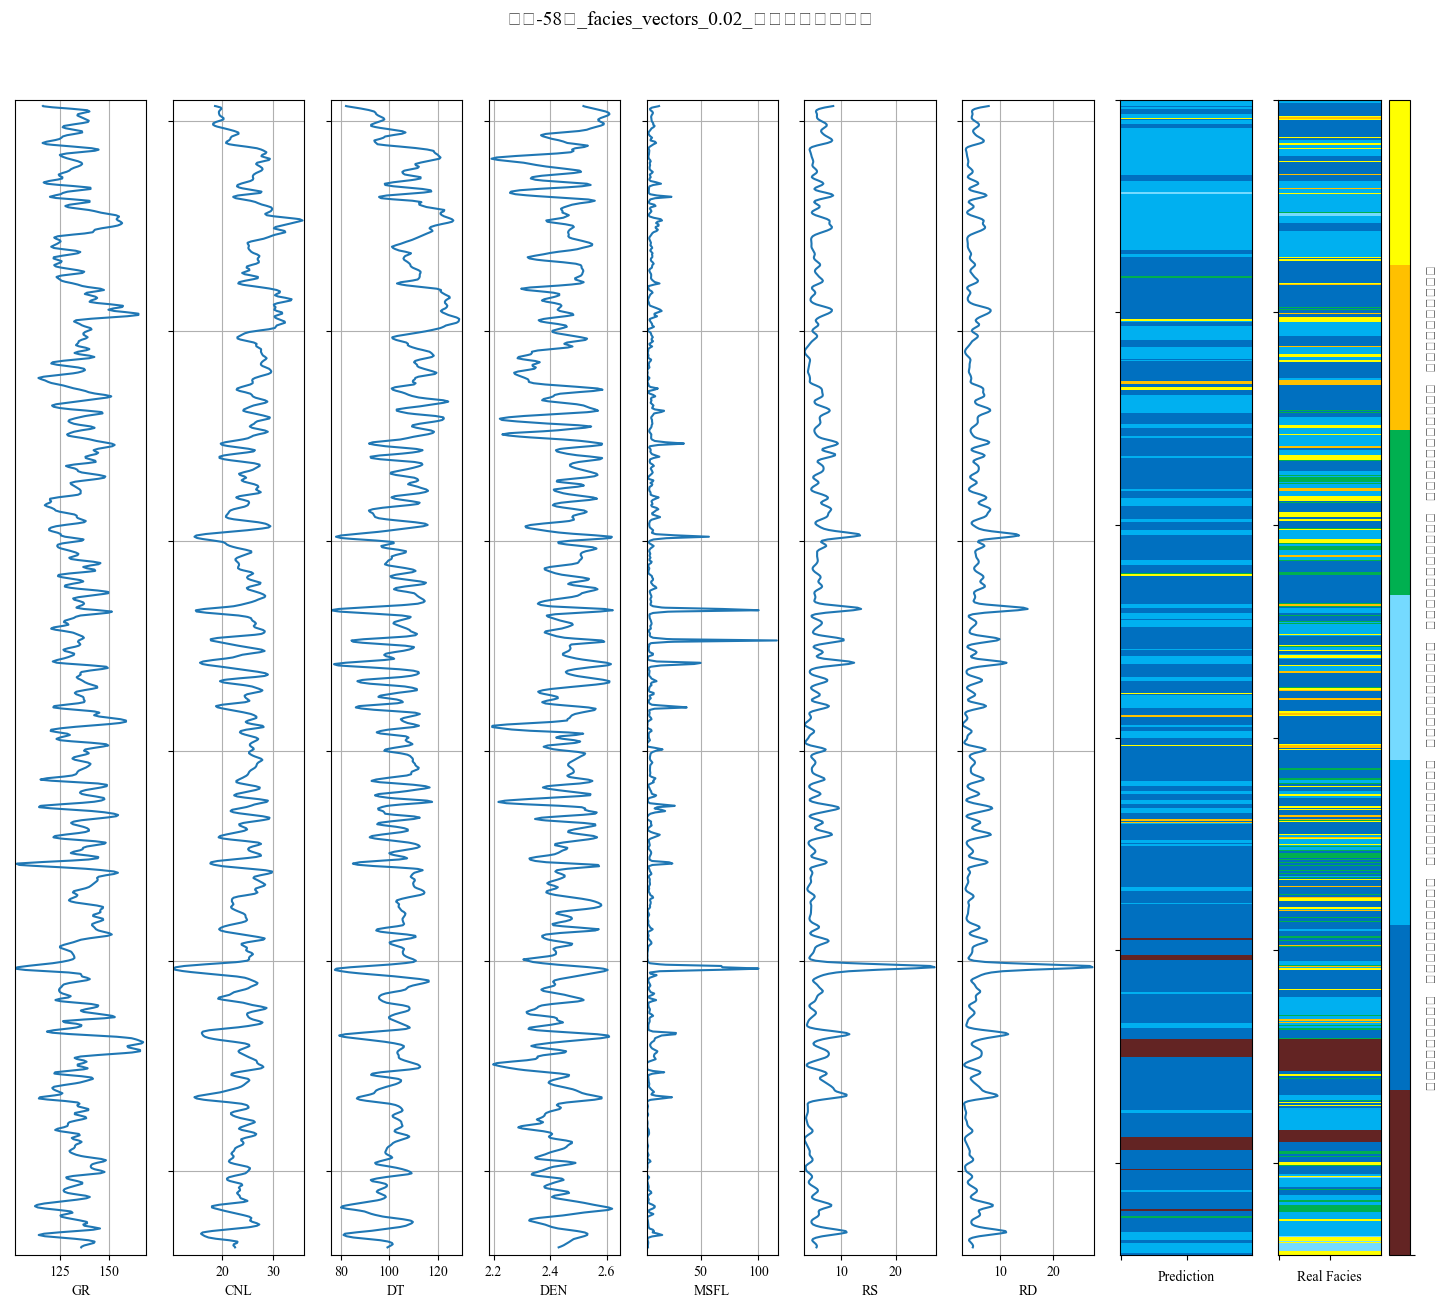

In [160]:
samples_index = np.arange(len(testALL_Y_predict_final))
if model_stage == "train":
    make_facies_log_plot_4(df_pred_data,samples_index,facies_colors_use)
else:
    if add_flag ==2:
        reference_facies = pd.DataFrame(High_R_Label, columns=[facies_labels_col])
        df_pred_data = pd.concat([df_pred_data,reference_facies],axis=1)
        make_facies_log_plot_4(df_pred_data,samples_index,facies_colors_use)
    else:
        make_facies_log_plot_2(df_pred_data,samples_index,facies_colors_use)

In [161]:
# make_facies_log_plot_4(df_pred_data,samples_index,facies_colors_use)

## Plot confused matrix（绘制混淆矩阵）

绘制混淆矩阵，预测结果与真实标定对比

In [162]:
# if class_begin == 1:
#     testALL_Y_predict_final = testALL_Y_predict_final - 1
# else:
#     testALL_Y_predict_final = testALL_Y_predict_final

In [163]:
# len(High_R_Label),len(testALL_Y_predict_final),class_begin

### Whether or not to perform lithofacies merging（是否执行岩相合并）

facies_colors = ['#632423', '#0070C0','#00B0F0','#75DAFF','#00B050','#FFC000', '#FFFF00']

facies_labels = ['高有机质层状页岩相', '高有机质纹层状页岩相','中有机质纹层状页岩相','低有机质纹层状页岩相',
                '中低有机质块状白云岩相', '低有机质块状介壳灰岩相', '低有机质块状粉砂岩相']

In [164]:
# merge_list = {2: 1, 3: 1, 4: 2, 5:3, 6:3}
merge_list = {2: 4, 3: 4, 5: 4}
# 前面的数字为要换的岩相，后面的数字为换的岩相。
# merge_list = {13:13, 8: 12, 11: 12, 9: 10, 7:10,3:6 ,5:6, 2:4, 1:1}

In [165]:
for i in merge_list:
    print(type(i),type(merge_list[i]))
    replace_str = str(i)
    

<class 'int'> <class 'int'>
<class 'int'> <class 'int'>
<class 'int'> <class 'int'>


In [166]:
# np.unique(df_pred_data['Facies'])

In [167]:
execute_merge_label = False   # False  | True
# execute_merge_label = True
# 合并成四类


merge_list = {2: 4, 3: 4, 5: 4}
if (add_flag ==2 and execute_merge_label == True):
#     concanate_facies_labels = ['有机质层状页岩相', '有机质纹层状页岩相', '有机质块状白云岩相',  '有机质块状介壳灰岩粉砂岩相']
#     concanate_facies_labels = ['灰岩、云岩', '纹层状长英质页岩', '层状长英质页岩',  '纹层状粘土质页岩', '层状粘土质页岩','块状粘土质页岩']
    
#     concanate_facies_colors = ['#632423', '#00B0F0','#00B050', '#FFFF00']
#     concanate_facies_colors = ['#632423', '#00B0F0','#00B050', '#FFFF00','#999999']
    
    concanate_facies_colors = ['#00B0F0', '#FFFF00','#007F00']

    concanate_facies_labels = ['砂岩', '页岩','灰岩、云岩']


    for i in merge_list:
        # Series.replace(self, to_replace=None, value=None, inplace=False, limit=None, regex=False, method='pad')
        # 要注意这样的操作并没有改变文档的源数据，要改变源数据需要使用inplace = True
        High_R_Label.replace(to_replace = i, value = merge_list[i],inplace=True)
        # pred_facies.replace(to_replace=r'^replace_str.$', value = merge_list[i], regex=True)
        pred_facies.replace(to_replace= i, value = merge_list[i],inplace=True)
   

In [168]:
# np.unique(pred_facies),np.unique(High_R_Label)

In [169]:
add_flag

2

In [170]:
def make_facies_log_plot_5(logs,sample_index, facies_colors):
    # 用于绘制合并后的图
    #make sure logs are sorted by depth
    # logs = logs.sort_values(by = DEPTH_col_name)
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    # sample_index = np.arange(len(AB_G))
    if use_depth_log == True:
        ztop = logs[DEPTH_col_name].min(); zbot = logs[DEPTH_col_name].max()
        Depth_col = logs[DEPTH_col_name]
        print(ztop,zbot)
    else:
        ztop = 0; zbot = len(logs)
        Depth_col = sample_index
    
    cluster1 = np.repeat(np.expand_dims(logs["Prediction"].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[facies_labels_col].values,1), 100, 1)
    total_fig_cols = len(input_vectors)+ 2
    f, ax = plt.subplots(nrows=1, ncols=len(input_vectors) + 2, figsize=(total_fig_cols * 2,15))
    for i in range(len(input_vectors)):
        ax[i].plot(logs[input_vectors[i]], Depth_col)
    final_line = len(input_vectors)
    if (add_flag == 1) or (add_flag ==2):
        im1 = ax[final_line].imshow(cluster1, interpolation='none', aspect='auto',
                        cmap=cmap_facies,vmin = 0,vmax = len(facies_colors))
        im2 = ax[final_line+1].imshow(cluster2, interpolation='none', aspect='auto',
                        cmap=cmap_facies,vmin = 0,vmax = len(facies_colors))
    
        divider = make_axes_locatable(ax[final_line+1])
        cax = divider.append_axes("right", size="20%", pad=0.05)
        cbar=plt.colorbar(im2, cax=cax)
        cbar.set_label((25*' ').join(facies_labels))
        cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
        ax[i].set_xlabel(input_vectors[i])
        ax[i].set_xlim(logs[input_vectors[i]].min() - 0.01,logs[input_vectors[i]].max() * 1.02)
        ax[i].set_ylim(math.floor(ztop), math.ceil(zbot))
        
    for i in range(len(ax)-2):
        # ax[i].set_ylim(ztop,zbot)
        ax[i].set_yticklabels([])
    ax[0].set_yticks([])
    
        
    if (add_flag == 1) or (add_flag ==2):
        ax[final_line].set_xlabel('Prediction')
        ax[final_line + 1].set_xlabel('Real Facies')
        ax[final_line].set_yticklabels([])
        ax[final_line].set_xticklabels([])
        ax[final_line + 1].set_yticklabels([])
        ax[final_line + 1].set_xticklabels([])
    # f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)
    f.suptitle( str(well_name) + "_全部样本预测结果", fontsize=14,y=0.94)
    if model_stage == "train":
        pred_image_save_path = model_training_img_file_saving_path 
        pred_image_name = model_training_img_name
    else:
        pred_image_save_path = model_testing_img_file_saving_path 
        pred_image_name = model_testing_image_name
    print(pred_image_save_path)
    plt.savefig(os.path.join(pred_image_save_path, pred_image_name  + '_Merger_PredictionAll.png'), dpi=96,  bbox_inches='tight')

In [171]:
if (add_flag ==2 and execute_merge_label == True):
    if (flag == 1) or (flag == 2):
        df_pred_data = pd.concat([fianl_DEPTH,inputX,pred_facies],axis=1) 
    else:
        input_AB_X = inputX[seq_length:].reset_index(drop = True)
        df_pred_data = pd.concat([fianl_DEPTH,input_AB_X,pred_facies],axis=1)
        
        reference_facies = pd.DataFrame(High_R_Label, columns=[facies_labels_col])
        df_pred_data = pd.concat([df_pred_data,reference_facies],axis=1)
        
        

In [172]:
if (add_flag ==2 and execute_merge_label == True):
    make_facies_log_plot_5(df_pred_data,samples_index,facies_colors)

In [173]:
if add_flag ==2:
    cv_conf = confusion_matrix(High_R_Label, pred_facies)
    print(cv_conf)

[[ 109  101    0    0    0    0    0]
 [  68 1915  600    0    7    6   17]
 [   0  887  603    2   13    0    1]
 [   0   11   54    0    0    0    0]
 [   9  287   60    0   10    5    1]
 [   0  135   51    1    1   19    8]
 [   0  298  131    6    0    6   11]]


In [174]:
if add_flag ==2:
    new_label_index = np.unique(High_R_Label)

    new_facies_labels = []
    # 关键在于 input_vectors''
    for i in new_label_index:
        new_facies_labels.append(facies_labels[i])

    print(new_facies_labels)

['高有机质层状页岩相', '高有机质纹层状页岩相', '中有机质纹层状页岩相', '低有机质纹层状页岩相', '中低有机质块状白云岩相', '低有机质块状介壳灰岩相', '低有机质块状粉砂岩相']


     Pred   高有机质层状页岩相  高有机质纹层状页岩相  中有机质纹层状页岩相  低有机质纹层状页岩相 中低有机质块状白云岩相 低有机质块状介壳灰岩相  低有机质块状粉砂岩相       Total
     True
      高有机质层状页岩相         109         101                                                                     210
     高有机质纹层状页岩相          68        1915         600                       7           6          17        2613
     中有机质纹层状页岩相                     887         603           2          13                       1        1506
     低有机质纹层状页岩相                      11          54                                                          65
    中低有机质块状白云岩相           9         287          60                      10           5           1         372
    低有机质块状介壳灰岩相                     135          51           1           1          19           8         215
     低有机质块状粉砂岩相                     298         131           6                       6          11         452


e:\论文撰写\基于井相似性的样本权重迁移的测井评价方法\code\Facies_classification_TF2.X\classification_utilities.py:13: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall)
d:\Program Files\Python310\lib\site-packages\seaborn\matrix.py:342: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  ax.figure.draw(ax.figure.canvas.get_renderer())
d:\Program Files\Python310\lib\site-packages\seaborn\matrix.py:342: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from current font.
  ax.figure.draw(ax.figure.canvas.get_renderer())
d:\Program Files\Python310\lib\site-packages\seaborn\matrix.py:342: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from current font.
  ax.figure.draw(ax.figure.canvas.get_renderer())
d:\Program Files\Python310\lib\site-packages\seaborn\matrix.py:342: UserWarning: Glyph 36136 (\N{CJK UNIFIED IDEOGRAPH-8D28}) missing from current font.
  ax.figure.draw(ax.figure.canva

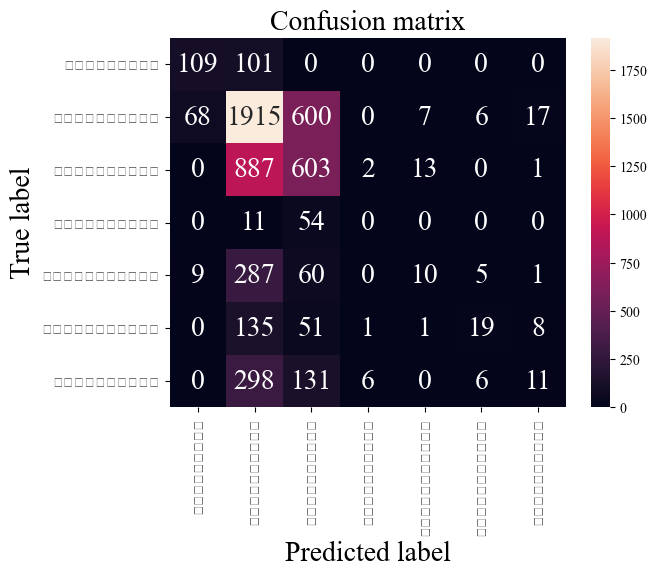

In [175]:
if add_flag ==2:
    cv_conf = confusion_matrix(High_R_Label, pred_facies)
    display_cm(cv_conf, new_facies_labels, hide_zeros=True)
#     plt.figure(figsize=(8,8))
    sns.heatmap(cv_conf, xticklabels = new_facies_labels, yticklabels = new_facies_labels, annot=True, fmt="d", annot_kws={"size": 20});
    plt.title("Confusion matrix", fontsize=20)
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    # plt.savefig(os.path.join(model_testing_img_file_saving_path,model_testing_image_name  + '_all_confusion_matrix.png'), dpi=96,  bbox_inches='tight')
#     plt.savefig(str(model_testing_img_file_saving_path + "/" + model_testing_image_name  + '_all_confusion_matrix.png'), dpi=96,  bbox_inches='tight')
    plt.show()

In [176]:
# conf,cv_conf

In [177]:
if (add_flag == 1) or (add_flag ==2):
    print('Facies classification accuracy = %f' % accuracy(cv_conf))
#     print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(cv_conf, adjacent_facies))

Facies classification accuracy = 0.490889


In [178]:
if (add_flag == 1) or (add_flag ==2):
    per_class_accuracy_list = per_class_accuracy(cv_conf)
    for i in range(len(per_class_accuracy_list)):
        print(i,' class facies classification accuracy = %f' % per_class_accuracy_list[i])

210
2613
1506
65
372
215
452
0  class facies classification accuracy = 0.519048
1  class facies classification accuracy = 0.732874
2  class facies classification accuracy = 0.400398
3  class facies classification accuracy = 0.000000
4  class facies classification accuracy = 0.026882
5  class facies classification accuracy = 0.088372
6  class facies classification accuracy = 0.024336


## Predicted vs. true calibration ROC（预测值与真实标定值ROC）

In [179]:
if (model_stage == "train") :
    pred_X = dataX
else:
    pred_X = testALL_A_X

In [180]:
if (add_flag == 1) or (add_flag ==2):
    if add_flag == 1:
        loss, accuracy = model.evaluate(pred_X, all_y, verbose=2)
        print("accuracy:",accuracy)
    n_classes = len(facies_labels)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(all_y[:, i], A_Y_predict[:, i])   
        #max_test样例真实标签，max_predictions学习器预测的样例的概率 
        roc_auc[i] = auc(fpr[i], tpr[i])   
        #计算ROC曲线下方的面积，fpr假正例率数组(横坐标)，tpr真正例率数组(纵坐标） 

In [181]:
if (add_flag == 1) or (add_flag ==2):
    fpr["micro"], tpr["micro"], _ = roc_curve(all_y.ravel(), A_Y_predict.ravel())   #ravel函数将矩阵展开成向量
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [182]:
if (add_flag == 1) or (add_flag ==2):
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))   #np.concatenate将“特征维度相同数组”纵向拼接

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)   #np.zeros_like创建一个和参数all_fpr数组维度相同的全0数组
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])   
            #interp一维线性插值，fpr和tpr是插值结点横纵坐标，all_fpr是已知中间节点横坐标(得到插值曲线后，求其纵坐标)
        #https://docs.scipy.org/doc/numpy/reference/generated/numpy.interp.html#numpy.interp

        # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

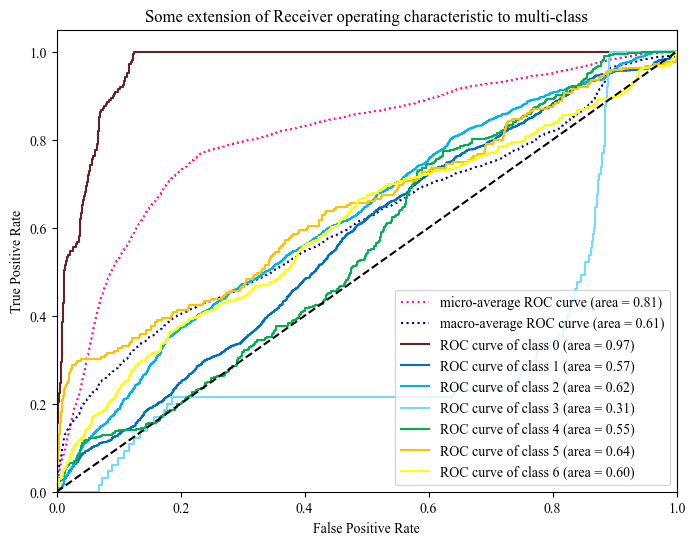

In [183]:
if (add_flag == 1) or (add_flag ==2):
    plt.rcParams['figure.figsize']=(8,6)
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})' ''.format(roc_auc["micro"]),
                 color='deeppink', linestyle=':')

    plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.2f})' ''.format(roc_auc["macro"]),
                 color='navy', linestyle=':')

        # colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])   #python3里的无穷循环器
    line_colors = facies_colors_use
    for i, line_color in zip(range(n_classes), line_colors):
            plt.plot(fpr[i], tpr[i], color=line_color, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    if model_stage == "train":
        plt.savefig(os.path.join(model_training_img_file_saving_path, model_training_img_name +"_" + element_name + '_'+ str(n_layers) + "_layers_" +  "_lr_" + str(
            learning_rate) + "h_dim" + str(hidden_dim) + "_epoch_" + str(EPOCHS) + '_all_ROC.png'), dpi=330,  bbox_inches='tight')
    else:
        plt.savefig(os.path.join(model_testing_img_file_saving_path, model_testing_image_name + '_all_ROC.png'), dpi=330,  bbox_inches='tight')
    plt.show()

# The curve results are saved（曲线结果保存）

## Result file header information（结果文件文件头信息）

In [184]:
# filename_A ： 'HP1_orginLog_6D_4075m-4280m_R_0.125.csv'
well_name

'英斜-58井_facies_vectors_0.02'

In [185]:
if use_depth_log == True:
    print("begin_depth,end_depth:",begin_depth,end_depth)

begin_depth,end_depth: 2012.7 2121.4


In [186]:
resolution_ratio = 1 / resolution
resolution_ratio

0.02

## View the saved result curves（查看保存的结果曲线）

In [187]:
if (add_flag == 1) or (add_flag ==2):
    print(df_pred_data.shape,DEPTH_AddReslution.shape,well_name)

(5433, 13) (5433, 1) 英斜-58井_facies_vectors_0.02


In [188]:
# if use_low_R_data == True:
#     pd_data0 = pd.DataFrame(DEPTH_AddReslution,columns=["DEPTH"])
#     pd_data = pd.concat([pd_data0,df_pred_data],axis=1)
#         # 左右拼接 axis=1, 上下拼接 axis=0
#     pd_data.to_csv(csv_file_saving_path + well_name + "_"+ str(begin_depth) + "_"+ str(end_depth) + "m_" + element_name + '_Add_R_'+ sen.tid_maker() +'.txt',mode='w',float_format='%.4f',sep='\t',index=None,header=True)
#     print("add Resolution Algorithm is Finished!!")
# else:
#     if use_depth_log == True:
#         pd_data0 = pd.DataFrame(DEPTH_AddReslution,columns=["DEPTH"])
#         result_csv_name = well_name + "_"+ str(begin_depth) + "_"+ str(end_depth) + "m_" + element_name + '_Pred_R_'+ sen.tid_maker() +'.txt'
#     else:
#         pd_data0 = pd.DataFrame(all_sample_index,columns=["sample_index"])
#         result_csv_name = well_name + "_" + element_name + '_Pred_R_'+ sen.tid_maker() +'.txt'
#     pd_data1 = pd.DataFrame(testALL_Y_predict_final,columns=[element_name + "_pred"])
#     if use_high_R_data:
#         pd_data2 = pd.DataFrame(High_R_Label,columns=[element_name + "_High_R"])
#         pd_data = pd.concat([pd_data0,pd_data1,pd_data2],axis=1)
#     else:
#         pd_data = pd.concat([pd_data0,pd_data1],axis=1)
if "DEPTH" not in df_pred_data.columns:
    pd_data0 = pd.DataFrame(DEPTH_AddReslution,columns=["DEPTH"])
    pd_data = pd.concat([pd_data0,df_pred_data],axis=1) 
else:
    pd_data = df_pred_data
result_csv_name = well_name + "_" + element_name + '_Pred_R_'+ sen.tid_maker() +'.csv'
# pd_data.to_csv(csv_file_saving_path + result_csv_name,mode='w',float_format='%.4f',sep='\t',index=None,header=True)
pd_data.to_csv(csv_file_saving_path + result_csv_name,mode='w',float_format='%.4f',index=None,header=True)
print("Prediction Algorithm is Finished!!")

Prediction Algorithm is Finished!!


In [189]:
result_csv_name

'英斜-58井_facies_vectors_0.02_7_Pred_R_03131512.csv'

In [190]:
pd_data

,DEPTH,CAL,SP,GR,CNL,DT,DEN,MSFL,RS,RD,Well Name,Prediction,Facies
0,2012.70,9.3194,162.9254,135.9260,22.5154,99.3286,2.4298,4.5486,5.4064,4.8762,X58,2,2
1,2012.72,9.3192,162.9348,135.9580,22.5048,99.4648,2.4319,4.5328,5.4310,4.8957,X58,2,2
2,2012.74,9.3191,162.9443,135.9900,22.4943,99.6009,2.4340,4.5169,5.4557,4.9152,X58,2,2
3,2012.76,9.3207,162.9596,136.1114,22.4647,99.7579,2.4359,4.5053,5.4689,4.9252,X58,2,2
4,2012.78,9.3240,162.9807,136.3223,22.4160,99.9356,2.4376,4.4980,5.4706,4.9257,X58,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5428,2121.32,8.7243,167.6234,119.3030,19.2577,84.0799,2.5265,11.0547,7.5985,6.9465,X58,1,6
5429,2121.34,8.7238,167.5953,118.3255,19.1142,83.5490,2.5238,11.9526,7.8198,7.1718,X58,1,6
5430,2121.36,8.7234,167.5671,117.3481,18.9706,83.0182,2.5210,12.8506,8.0410,7.3970,X58,1,6
5431,2121.38,8.7227,167.5484,116.5944,18.8103,82.5417,2.5187,13.6404,8.2642,7.6268,X58,1,6


In [191]:
if paly_music == True:
    mixer.init()
    music_path = "music/"
    file = "MISIA - 星のように.mp3"
    music_file = os.path.join(music_path,file)
    mixer.music.load(music_file)
    mixer.music.play()
    time.sleep(6)
    mixer.music.stop()
        # exit()